In [ ]:
!pip install scikeras

In [ ]:
!pip install stable-baselines3 gym gymnasium shimmy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 24.0 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade imbalanced-learn scikit-learn

In [ ]:
!pip install scikeras

In [ ]:
!pip install shap

In [ ]:
pip install shap matplotlib scikit-learn xgboost

In [ ]:
#import all the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from xgboost import XGBClassifier
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Concatenate, Attention, Flatten
from keras.models import Model
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from itertools import cycle
import warnings
import shap
warnings.filterwarnings("ignore")


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [ ]:
#Read the dataset
df_mimic = pd.read_csv('mimic3d.csv')
df_mimic.head()

,hadm_id,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,...,NumMicroLabs,NumNotes,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum
0,100001,F,35,6.17,EMERGENCY,CLINIC REFERRAL/PREMATURE,DIABETIC KETOACIDOSIS,Private,PROTESTANT QUAKER,DIVORCED,...,0.65,0.05,5.19,14.91,1.13,0.65,398.70,0,493.89,1
1,100003,M,59,4.04,EMERGENCY,EMERGENCY ROOM ADMIT,UPPER GI BLEED,Private,NOT SPECIFIED,SINGLE,...,1.24,1.59,5.45,7.18,0.99,1.24,373.02,0,465.71,1
2,100006,F,48,12.04,EMERGENCY,EMERGENCY ROOM ADMIT,COPD FLARE,Private,NOT SPECIFIED,SINGLE,...,0.33,0.15,4.15,6.23,0.00,0.33,286.21,0,344.00,3
3,100007,F,73,7.29,EMERGENCY,EMERGENCY ROOM ADMIT,BOWEL OBSTRUCTION,Private,JEWISH,MARRIED,...,0.69,0.17,9.05,11.52,0.00,0.96,526.06,0,603.05,1
4,100009,M,60,4.88,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,CORONARY ARTERY DISEASE,Private,CATHOLIC,MARRIED,...,0.61,0.34,16.19,25.00,2.87,2.05,554.92,0,679.84,1


In [ ]:
# Function to generate random datetime
def random_dates(start, end, n):
    start_u = start.value//10**9
    end_u = end.value//10**9
    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s')

# Generate random intime values
np.random.seed(42)  # For reproducibility
start_date = pd.to_datetime('2022-01-01')
end_date = pd.to_datetime('2023-12-31')
df_mimic['intime'] = random_dates(start_date, end_date, df_mimic.shape[0])

# Generate outtime values based on intime and LOSdays
df_mimic['outtime'] = df_mimic['intime'] + pd.to_timedelta(df_mimic['LOSdays']*24*60*60, unit='s')

print(df_mimic[['hadm_id', 'intime', 'outtime']])

       hadm_id              intime             outtime
0       100001 2023-10-19 21:17:16 2023-10-26 01:22:04
1       100003 2023-07-29 15:21:50 2023-08-02 16:19:26
2       100006 2023-10-21 08:38:02 2023-11-02 09:35:38
3       100007 2023-12-01 05:23:19 2023-12-08 12:20:55
4       100009 2022-09-02 00:03:08 2022-09-06 21:10:20
...        ...                 ...                 ...
58971   199993 2023-01-22 17:51:36 2023-02-16 07:46:48
58972   199994 2022-07-02 03:31:08 2022-07-11 21:31:08
58973   199995 2022-09-04 08:49:04 2022-09-21 02:49:04
58974   199998 2022-06-05 22:29:20 2022-06-11 19:36:32
58975   199999 2023-05-15 20:54:10 2023-05-21 08:54:10

[58976 rows x 3 columns]


In [ ]:
'''# Python code to split intime and outtime columns into day, month, year
df_mimic['intime'] = pd.to_datetime(df_mimic['intime'], format='%d/%m/%Y %H:%M')
df_mimic['outtime'] = pd.to_datetime(df_mimic['outtime'], format='%d/%m/%Y %H:%M')

# Split intime and outtime into day, month, year
df_mimic['intime_day'] = df_mimic['intime'].dt.day
df_mimic['intime_month'] = df_mimic['intime'].dt.month
df_mimic['intime_year'] = df_mimic['intime'].dt.year

df_mimic['outtime_day'] = df_mimic['outtime'].dt.day
df_mimic['outtime_month'] = df_mimic['outtime'].dt.month
df_mimic['outtime_year'] = df_mimic['outtime'].dt.year

print(df_mimic[['hadm_id', 'intime', 'outtime', 'intime_day', 'intime_month', 'intime_year', 'outtime_day', 'outtime_month', 'outtime_year']])'''

       hadm_id              intime             outtime  intime_day  \
0       100001 2023-10-19 21:17:16 2023-10-26 01:22:04          19   
1       100003 2023-07-29 15:21:50 2023-08-02 16:19:26          29   
2       100006 2023-10-21 08:38:02 2023-11-02 09:35:38          21   
3       100007 2023-12-01 05:23:19 2023-12-08 12:20:55           1   
4       100009 2022-09-02 00:03:08 2022-09-06 21:10:20           2   
...        ...                 ...                 ...         ...   
58971   199993 2023-01-22 17:51:36 2023-02-16 07:46:48          22   
58972   199994 2022-07-02 03:31:08 2022-07-11 21:31:08           2   
58973   199995 2022-09-04 08:49:04 2022-09-21 02:49:04           4   
58974   199998 2022-06-05 22:29:20 2022-06-11 19:36:32           5   
58975   199999 2023-05-15 20:54:10 2023-05-21 08:54:10          15   

       intime_month  intime_year  outtime_day  outtime_month  outtime_year  
0                10         2023           26             10          2023  
1    

In [ ]:
df_mimic.head()

,hadm_id,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,...,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum,intime,outtime
0,100001,F,35,6.17,EMERGENCY,CLINIC REFERRAL/PREMATURE,DIABETIC KETOACIDOSIS,Private,PROTESTANT QUAKER,DIVORCED,...,5.19,14.91,1.13,0.65,398.70,0,493.89,1,2023-10-19 21:17:16,2023-10-26 01:22:04
1,100003,M,59,4.04,EMERGENCY,EMERGENCY ROOM ADMIT,UPPER GI BLEED,Private,NOT SPECIFIED,SINGLE,...,5.45,7.18,0.99,1.24,373.02,0,465.71,1,2023-07-29 15:21:50,2023-08-02 16:19:26
2,100006,F,48,12.04,EMERGENCY,EMERGENCY ROOM ADMIT,COPD FLARE,Private,NOT SPECIFIED,SINGLE,...,4.15,6.23,0.00,0.33,286.21,0,344.00,3,2023-10-21 08:38:02,2023-11-02 09:35:38
3,100007,F,73,7.29,EMERGENCY,EMERGENCY ROOM ADMIT,BOWEL OBSTRUCTION,Private,JEWISH,MARRIED,...,9.05,11.52,0.00,0.96,526.06,0,603.05,1,2023-12-01 05:23:19,2023-12-08 12:20:55
4,100009,M,60,4.88,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,CORONARY ARTERY DISEASE,Private,CATHOLIC,MARRIED,...,16.19,25.00,2.87,2.05,554.92,0,679.84,1,2022-09-02 00:03:08,2022-09-06 21:10:20


In [ ]:
# Define arrival transport options and their adjusted probabilities based on 58976 rows
arrival_transport_options = ['WALK IN', 'AMBULANCE', 'UNKNOWN', 'OTHER', 'HELICOPTER']
arrival_transport_counts = [251849, 155752, 15352, 1266, 868]

# Normalize probabilities to sum to 1
total_counts = sum(arrival_transport_counts)
probabilities = [count / total_counts for count in arrival_transport_counts]

# Generate arrival_transport column
np.random.seed(42)  # For reproducibility
df_mimic['arrival_transport'] = np.random.choice(arrival_transport_options, size=len(df_mimic), p=probabilities)

print(df_mimic[['hadm_id', 'arrival_transport']])

       hadm_id arrival_transport
0       100001           WALK IN
1       100003         AMBULANCE
2       100006         AMBULANCE
3       100007         AMBULANCE
4       100009           WALK IN
...        ...               ...
58971   199993           WALK IN
58972   199994         AMBULANCE
58973   199995        HELICOPTER
58974   199998           WALK IN
58975   199999         AMBULANCE

[58976 rows x 2 columns]


In [ ]:
#top 5 rows of dataset
df_mimic.head()

,hadm_id,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,...,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum,intime,outtime,arrival_transport
0,100001,F,35,6.17,EMERGENCY,CLINIC REFERRAL/PREMATURE,DIABETIC KETOACIDOSIS,Private,PROTESTANT QUAKER,DIVORCED,...,14.91,1.13,0.65,398.70,0,493.89,1,2023-10-19 21:17:16,2023-10-26 01:22:04,WALK IN
1,100003,M,59,4.04,EMERGENCY,EMERGENCY ROOM ADMIT,UPPER GI BLEED,Private,NOT SPECIFIED,SINGLE,...,7.18,0.99,1.24,373.02,0,465.71,1,2023-07-29 15:21:50,2023-08-02 16:19:26,AMBULANCE
2,100006,F,48,12.04,EMERGENCY,EMERGENCY ROOM ADMIT,COPD FLARE,Private,NOT SPECIFIED,SINGLE,...,6.23,0.00,0.33,286.21,0,344.00,3,2023-10-21 08:38:02,2023-11-02 09:35:38,AMBULANCE
3,100007,F,73,7.29,EMERGENCY,EMERGENCY ROOM ADMIT,BOWEL OBSTRUCTION,Private,JEWISH,MARRIED,...,11.52,0.00,0.96,526.06,0,603.05,1,2023-12-01 05:23:19,2023-12-08 12:20:55,AMBULANCE
4,100009,M,60,4.88,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,CORONARY ARTERY DISEASE,Private,CATHOLIC,MARRIED,...,25.00,2.87,2.05,554.92,0,679.84,1,2022-09-02 00:03:08,2022-09-06 21:10:20,WALK IN


In [ ]:
df_mimic.columns

Index(['hadm_id', 'gender', 'age', 'LOSdays', 'admit_type', 'admit_location',
       'AdmitDiagnosis', 'insurance', 'religion', 'marital_status',
       'ethnicity', 'NumCallouts', 'NumDiagnosis', 'NumProcs',
       'AdmitProcedure', 'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs',
       'NumNotes', 'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers',
       'NumChartEvents', 'ExpiredHospital', 'TotalNumInteract', 'LOSgroupNum',
       'intime', 'outtime', 'arrival_transport'],
      dtype='object')

In [ ]:
#Dimension of dataset
df_mimic.shape

(58976, 31)

In [ ]:
#Statistical Description of dataset
df_mimic.describe()

,hadm_id,age,LOSdays,NumCallouts,NumDiagnosis,NumProcs,NumCPTevents,NumInput,NumLabs,NumMicroLabs,...,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum,intime,outtime
count,58976.000000,58976.000000,58976.000000,58976.000000,58976.00000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,...,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976,58976
mean,149970.809584,53.005884,10.114955,0.099374,2.67596,0.785599,1.074118,30.379017,46.421124,1.219913,...,7.111594,9.593702,0.691903,1.093313,528.505172,0.099261,636.115579,1.360248,2023-01-01 20:54:19.557921792,2023-01-11 23:39:51.661014528
min,100001.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-01-01 00:10:17,2022-01-01 04:54:56
25%,124952.750000,43.000000,3.710000,0.000000,0.82000,0.210000,0.000000,4.850000,26.980000,0.160000,...,1.750000,4.330000,0.000000,0.380000,207.410000,0.000000,267.407500,0.000000,2022-07-03 17:17:54.750000128,2022-07-13 18:45:34
50%,149989.500000,59.000000,6.460000,0.000000,1.41000,0.420000,0.970000,13.990000,38.520000,0.510000,...,5.310000,8.370000,0.000000,0.650000,417.875000,0.000000,497.335000,1.000000,2023-01-02 19:09:49.500000,2023-01-12 21:01:30.500000
75%,174966.500000,73.000000,11.790000,0.160000,2.40000,0.710000,1.560000,34.360000,50.860000,1.350000,...,10.490000,12.270000,0.880000,1.060000,700.302500,0.000000,811.382500,2.000000,2023-07-04 02:49:24.249999872,2023-07-14 01:14:35
max,199999.000000,89.000000,294.630000,4.760000,450.00000,275.000000,225.000000,6825.000000,5175.000000,375.000000,...,375.000000,750.000000,100.000000,125.000000,49325.000000,1.000000,68600.000000,3.000000,2023-12-30 23:58:15,2024-05-10 05:31:16.999999998
std,28883.095213,26.028120,12.456231,0.163437,8.26559,3.558090,2.027148,62.430163,76.061561,4.236693,...,7.551822,12.601338,2.117615,3.169441,640.250063,0.299014,783.938087,1.130337,NaN,NaN


In [ ]:
#Info of dataset
df_mimic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   hadm_id            58976 non-null  int64         
 1   gender             58976 non-null  object        
 2   age                58976 non-null  int64         
 3   LOSdays            58976 non-null  float64       
 4   admit_type         58976 non-null  object        
 5   admit_location     58976 non-null  object        
 6   AdmitDiagnosis     58951 non-null  object        
 7   insurance          58976 non-null  object        
 8   religion           58518 non-null  object        
 9   marital_status     48848 non-null  object        
 10  ethnicity          58976 non-null  object        
 11  NumCallouts        58976 non-null  float64       
 12  NumDiagnosis       58976 non-null  float64       
 13  NumProcs           58976 non-null  float64       
 14  AdmitP

In [ ]:
df_mimic.isnull().sum()

,0
hadm_id,0
gender,0
age,0
LOSdays,0
admit_type,0
admit_location,0
AdmitDiagnosis,25
insurance,0
religion,458
marital_status,10128


In [ ]:
# Filling null values in 'AdmitDiagnosis', 'religion', and 'marital_status'
df_mimic['AdmitDiagnosis'].fillna(df_mimic['AdmitDiagnosis'].mode()[0], inplace=True)
df_mimic['religion'].fillna(df_mimic['religion'].mode()[0], inplace=True)
df_mimic['marital_status'].fillna(df_mimic['marital_status'].mode()[0], inplace=True)


In [ ]:
df_mimic.isnull().sum()

,0
hadm_id,0
gender,0
age,0
LOSdays,0
admit_type,0
admit_location,0
AdmitDiagnosis,0
insurance,0
religion,0
marital_status,0


In [ ]:
df_mimic['religion'].value_counts()

,count
religion,
CATHOLIC,21064
NOT SPECIFIED,11753
UNOBTAINABLE,8269
PROTESTANT QUAKER,7134
JEWISH,5314
OTHER,2696
EPISCOPALIAN,774
GREEK ORTHODOX,459
CHRISTIAN SCIENTIST,429


In [ ]:
df_mimic['LOSgroupNum'].value_counts()


,count
LOSgroupNum,
1,18755
0,16618
3,14261
2,9342


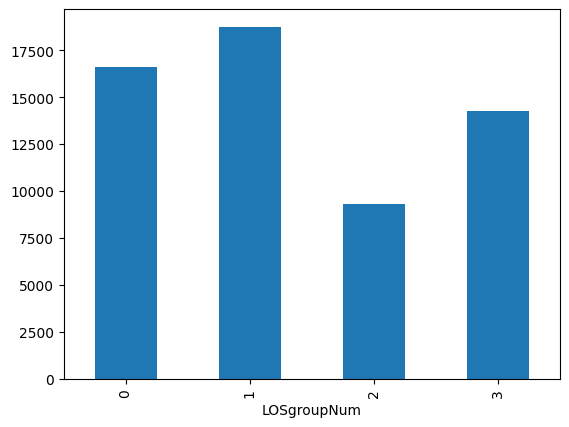

In [ ]:
df_mimic.groupby('LOSgroupNum').size().plot.bar()
plt.show()

In [ ]:
df_mimic =  df_mimic.drop('hadm_id', axis=1)

In [ ]:
df_mimic.shape

(58976, 30)

In [ ]:
# Filter data for Emergency and Urgent types
emergency_data = df_mimic[df_mimic['admit_type'].isin(['EMERGENCY', 'URGENT'])]

# Filter data for Emergency type
emerg_data = df_mimic[df_mimic['admit_type'].isin(['EMERGENCY'])]

#  Count patients with diseases
patients_with_disease = emerg_data[emerg_data['AdmitDiagnosis'].notnull()].shape[0]

# Method of arrival in Emergency department
method_of_arrival_counts = emerg_data['arrival_transport'].value_counts()

# Display the results
print(f"Number of patients visiting the Emergency department who had a disease: {patients_with_disease}")
print("\nMethod of arrival in the Emergency department:")
print(method_of_arrival_counts)

Number of patients visiting the Emergency department who had a disease: 42071

Method of arrival in the Emergency department:
arrival_transport
WALK IN       24922
AMBULANCE     15429
UNKNOWN        1508
OTHER           135
HELICOPTER       77
Name: count, dtype: int64


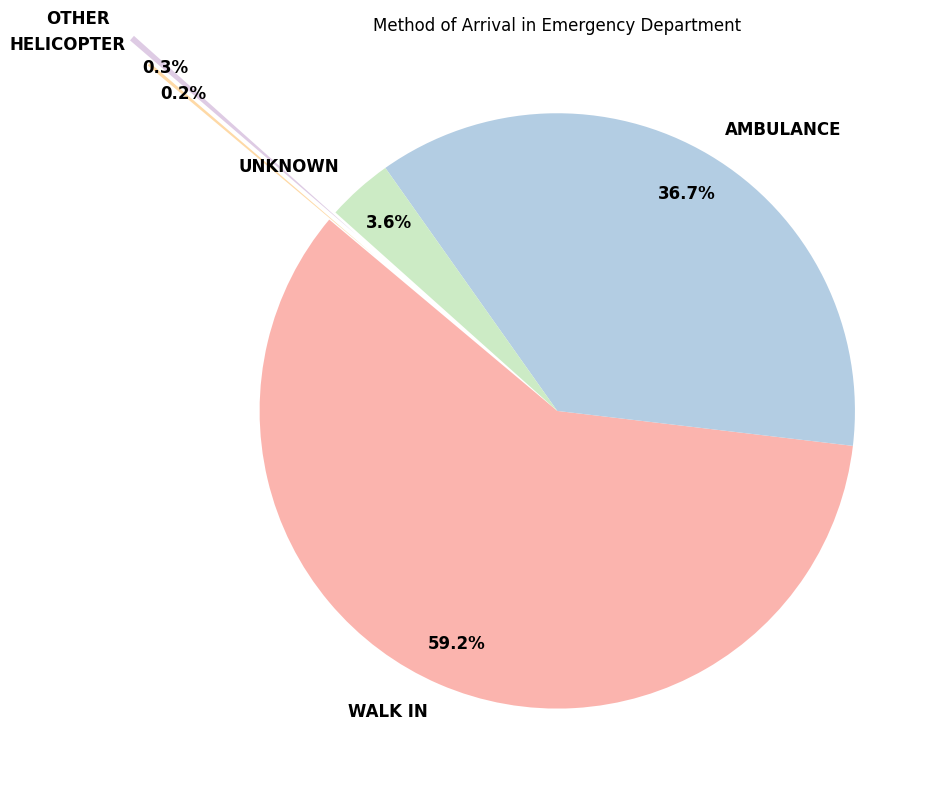

In [ ]:
# Data for pie chart
labels = method_of_arrival_counts.index
sizes = method_of_arrival_counts.values

# Explode the slices to make them more distinct
explode = (0, 0, 0, 0.9, 0.8)  # Further increase separation for UNKNOWN, OTHER, and HELICOPTER

# Plotting the pie chart
plt.figure(figsize=(13, 8))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, startangle=140,
                                   colors=plt.get_cmap('Pastel1').colors,
                                   autopct='%1.1f%%', pctdistance=0.85,
                                   textprops={'fontsize': 12, 'color': 'black', 'weight': 'bold'})

# Add annotations for the smaller slices
for i, (wedge, text) in enumerate(zip(wedges, texts)):
    if sizes[i] < 5:  # Adjust this value based on your data to select the small slices
        x, y = wedge.centroid
        plt.annotate(labels[i], xy=(x, y), xytext=(1.1 * x, 1.1 * y),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     horizontalalignment='center', verticalalignment='center',
                     fontsize=12, weight='bold')
    else:
        text.set_text(labels[i])

# Adding a title
plt.title('Method of Arrival in Emergency Department')

# Show the plot
plt.tight_layout()
plt.show()


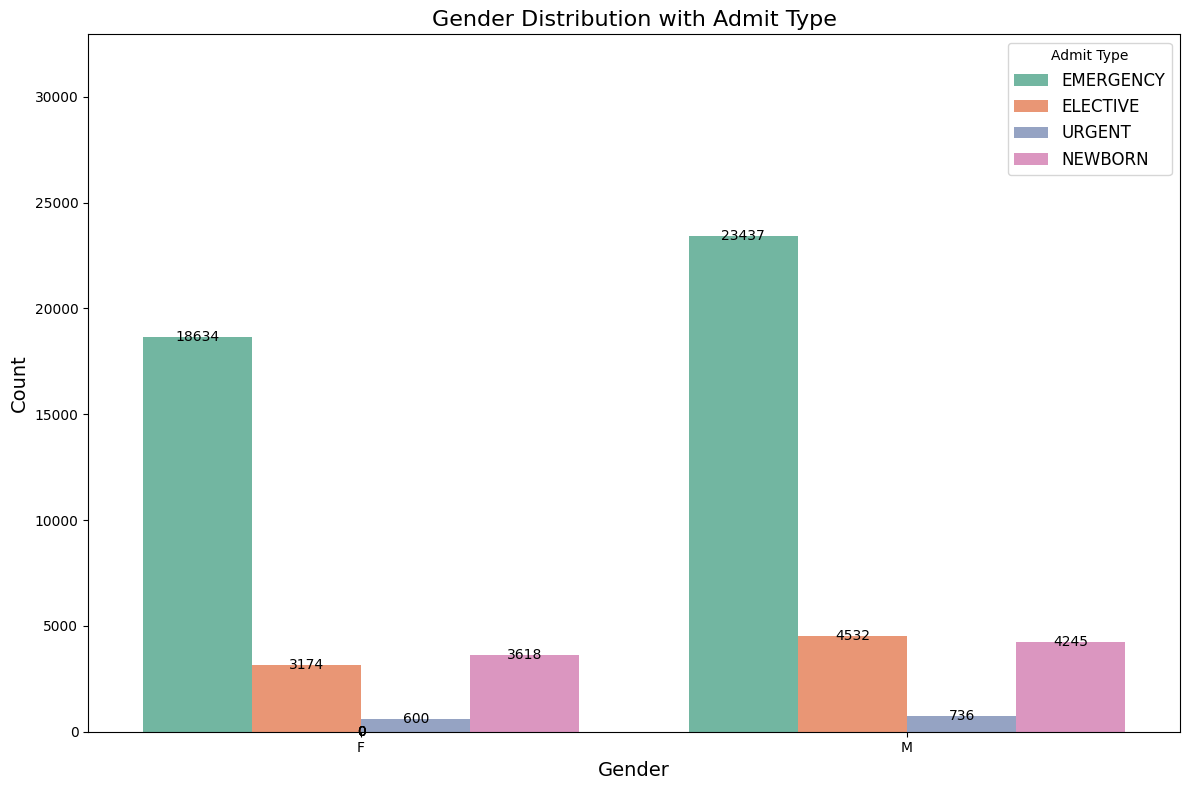

In [ ]:
# Create the count plot with a figure size
plt.figure(figsize=(12, 8))

# Create the count plot
ax = sns.countplot(data=df_mimic, x='gender', hue='admit_type', palette='Set2')

# Add counts on top of each bar
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2, p.get_height() + 0.5),
                ha='center', va='center', fontsize=10)

# Adjust y-axis limits to make it larger
plt.ylim(0, df_mimic['gender'].value_counts().max())  # Increase the y-axis limit by 20%

# Add title and labels
plt.title('Gender Distribution with Admit Type', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add legend with title
plt.legend(title='Admit Type', fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

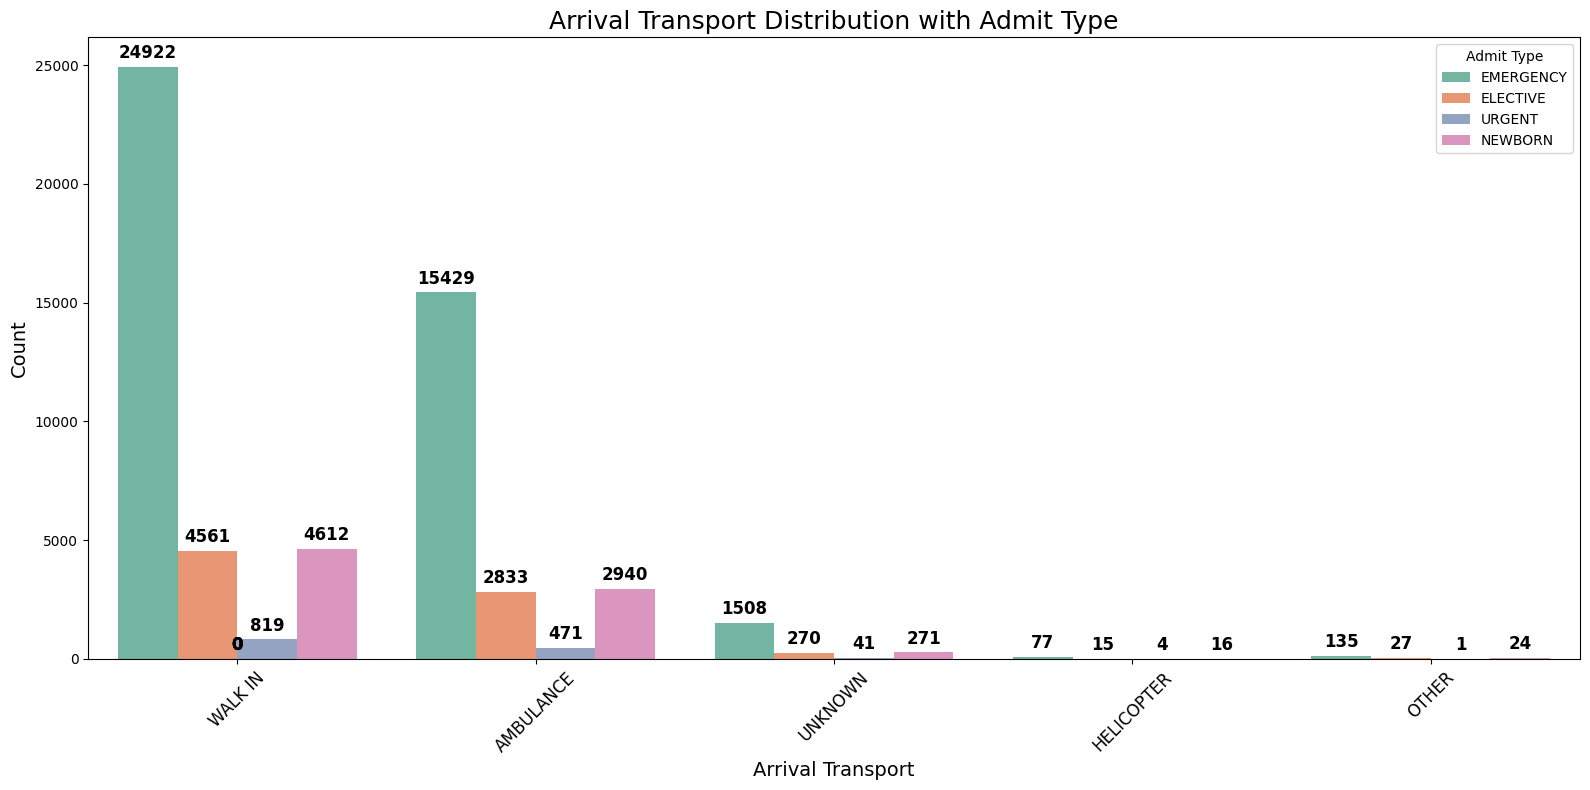

In [ ]:
# Create a figure size
plt.figure(figsize=(16, 8))  # Increase the size of the figure

# Create the countplot for arrival_transport using admit_type
ax = sns.countplot(data=df_mimic, x='arrival_transport', hue='admit_type', palette='Set2')

# Add the count on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=12, weight='bold')

# Add title and labels
plt.title('Arrival Transport Distribution with Admit Type', fontsize=18)
plt.xlabel('Arrival Transport', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45, fontsize=12)

# Add legend with title
plt.legend(title='Admit Type')

# Show the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

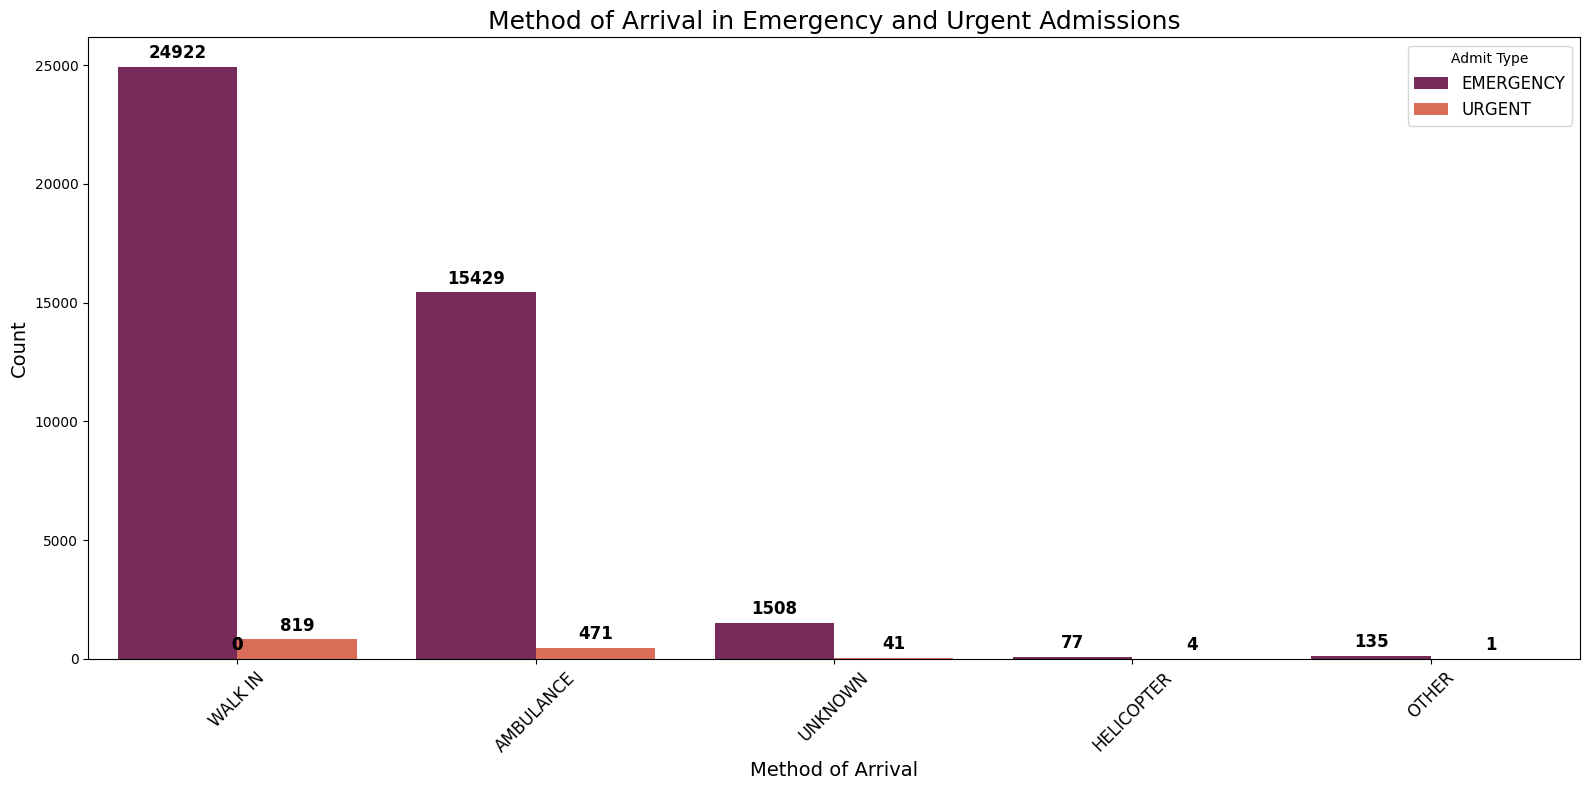

In [ ]:
# Create a figure size
plt.figure(figsize=(16, 8))  # Increase the size of the figure

# Create the countplot for arrival_transport using admit_type
ax = sns.countplot(data=emergency_data, x='arrival_transport', hue='admit_type', palette='rocket')

# Add the count on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=12, weight='bold')

# Add title and labels
plt.title('Method of Arrival in Emergency and Urgent Admissions', fontsize=18)
plt.xlabel('Method of Arrival', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45, fontsize=12)

# Add legend with title
plt.legend(title='Admit Type', fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

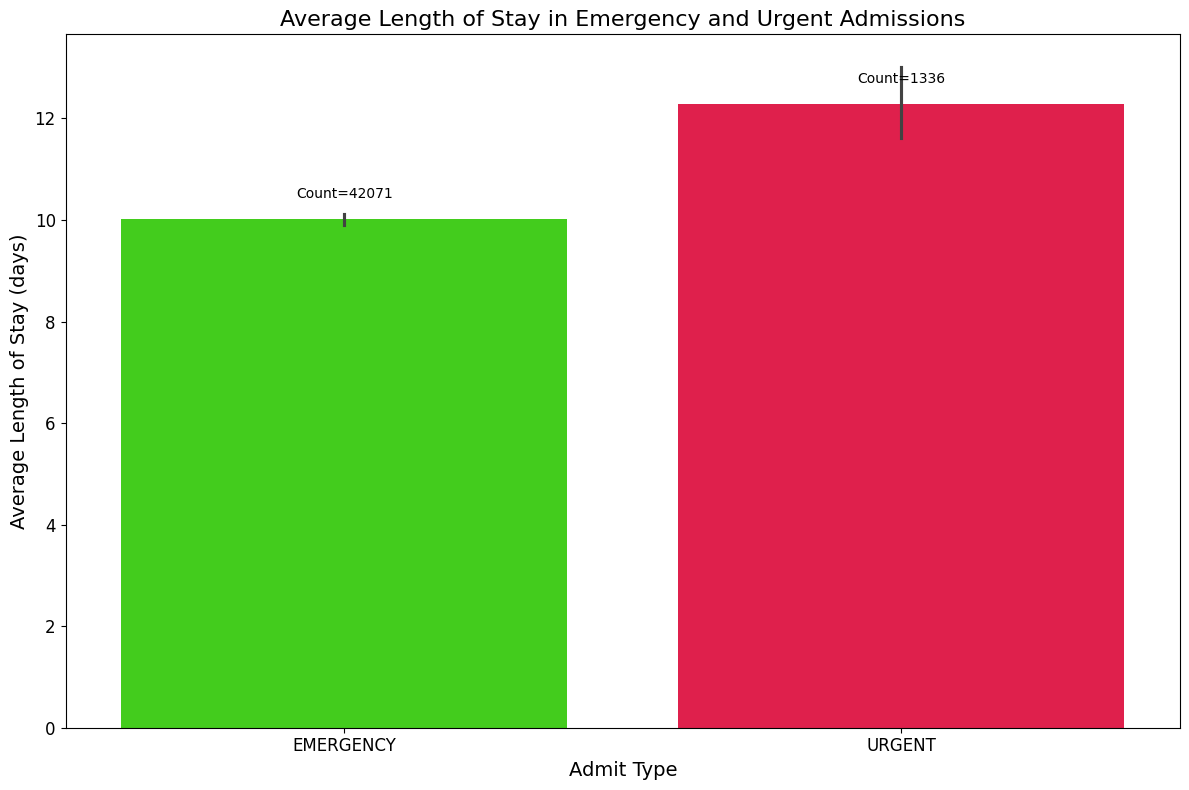

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Create the bar plot
ax = sns.barplot(data=emergency_data, x='admit_type', y='LOSdays', palette='prism')

# Calculate the number of observations for each admit_type
counts = emergency_data['admit_type'].value_counts()

# Add counts on top of each bar
for p in ax.patches:
    admit_type = p.get_x() + p.get_width() / 2
    count = counts.loc[ax.get_xticklabels()[int(admit_type)].get_text()]
    ax.annotate(f'Count={count}', (p.get_x() + p.get_width() / 2, p.get_height() + 0.5),
                ha='center', va='center', fontsize=10)

# Customize the chart
plt.title('Average Length of Stay in Emergency and Urgent Admissions', fontsize=16)
plt.xlabel('Admit Type', fontsize=14)
plt.ylabel('Average Length of Stay (days)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

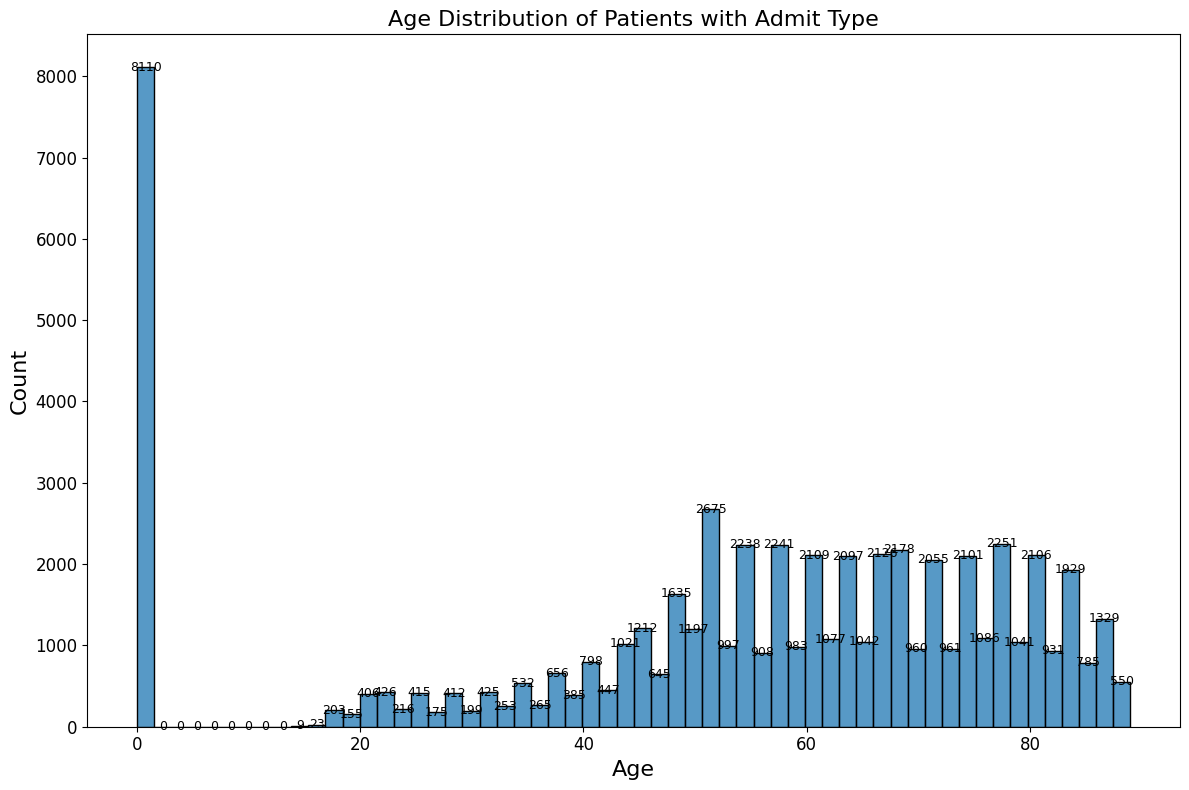

In [ ]:
# Create a figure for the plot
plt.figure(figsize=(12, 8))

# Create the histogram plot
ax = sns.histplot(data=df_mimic, x='age', kde=False)

# Add counts on top of each bin
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height + 0.5),
                ha='center', va='center', fontsize=9)

# Customize the chart
plt.title('Age Distribution of Patients with Admit Type', fontsize=16)
plt.xlabel('Age', fontsize= 16)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

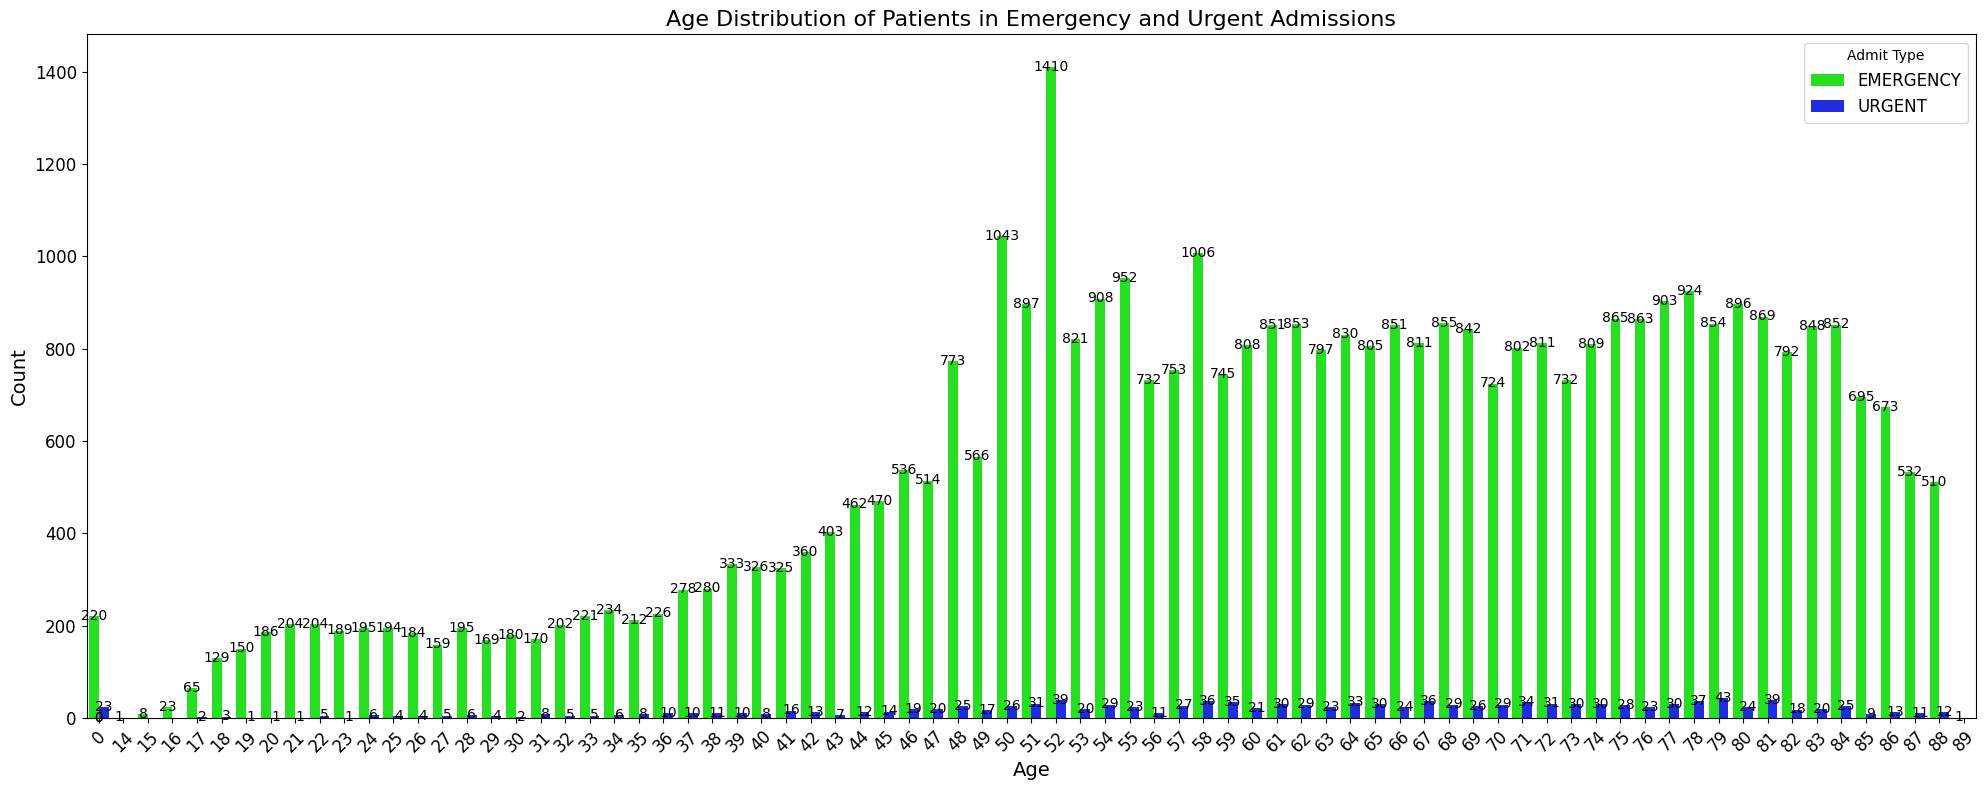

In [ ]:
# Create a figure for the plot
plt.figure(figsize=(20, 8))

# Create the count plot
ax = sns.countplot(data=emergency_data, x='age', hue='admit_type', palette='hsv')

# Add counts on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height() + 0.5),
                ha='center', va='center', fontsize=10)

# Customize the chart
plt.title('Age Distribution of Patients in Emergency and Urgent Admissions', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Admit Type', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

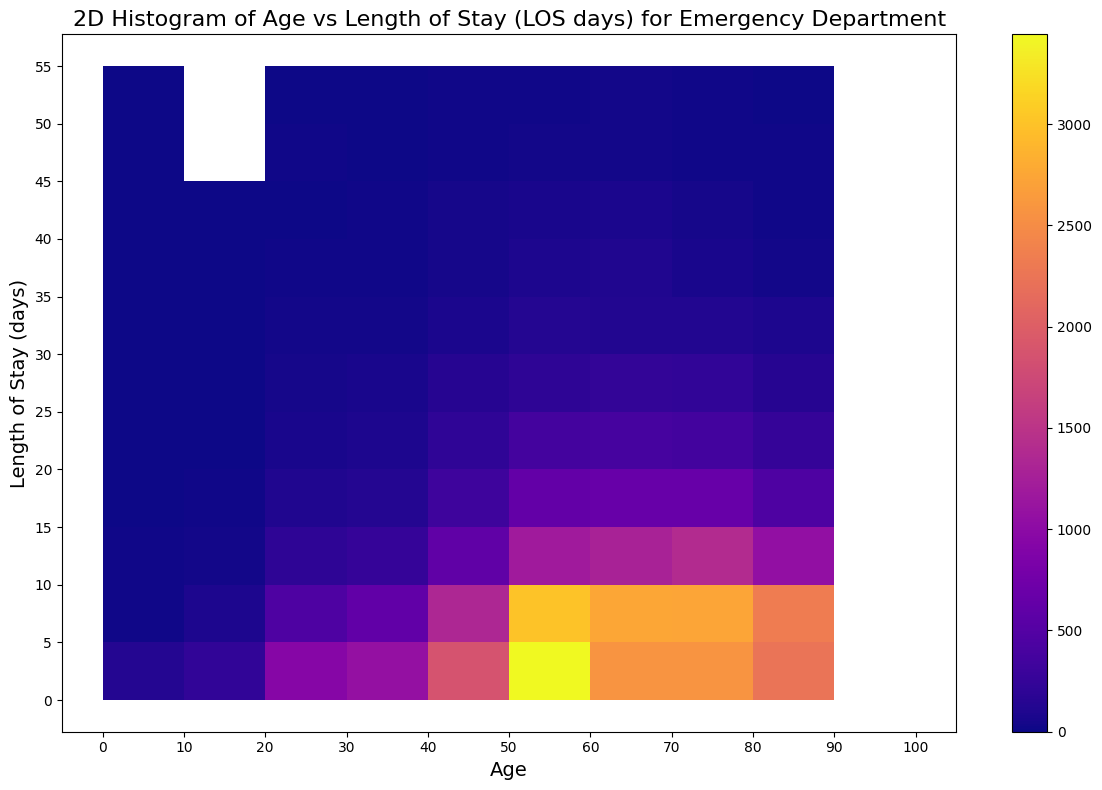

In [ ]:
# Filter data for Emergency Department
emergency_urgent_data = df_mimic[df_mimic['admit_type'] == 'EMERGENCY']

# Create the histogram for Age vs LOS days
plt.figure(figsize=(12, 8))
sns.histplot(data=emergency_urgent_data, x='age', y='LOSdays',
             bins=[range(0, 101, 10), np.arange(0, 56, 5)],
             cbar=True, cmap='plasma')

# Add labels and title
plt.title('2D Histogram of Age vs Length of Stay (LOS days) for Emergency Department', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Length of Stay (days)', fontsize=14)

# Set y-ticks with more space between them
# y_ticks = np.arange(0, emergency_urgent_data['LOSdays'].max() + 1, 10)  # Increase interval to 10 days
plt.yticks(range(0, 56, 5))

plt.xticks(range(0, 101, 10))  # Keep x-axis ticks at 10-year intervals
plt.tight_layout()

# Show plot
plt.show()


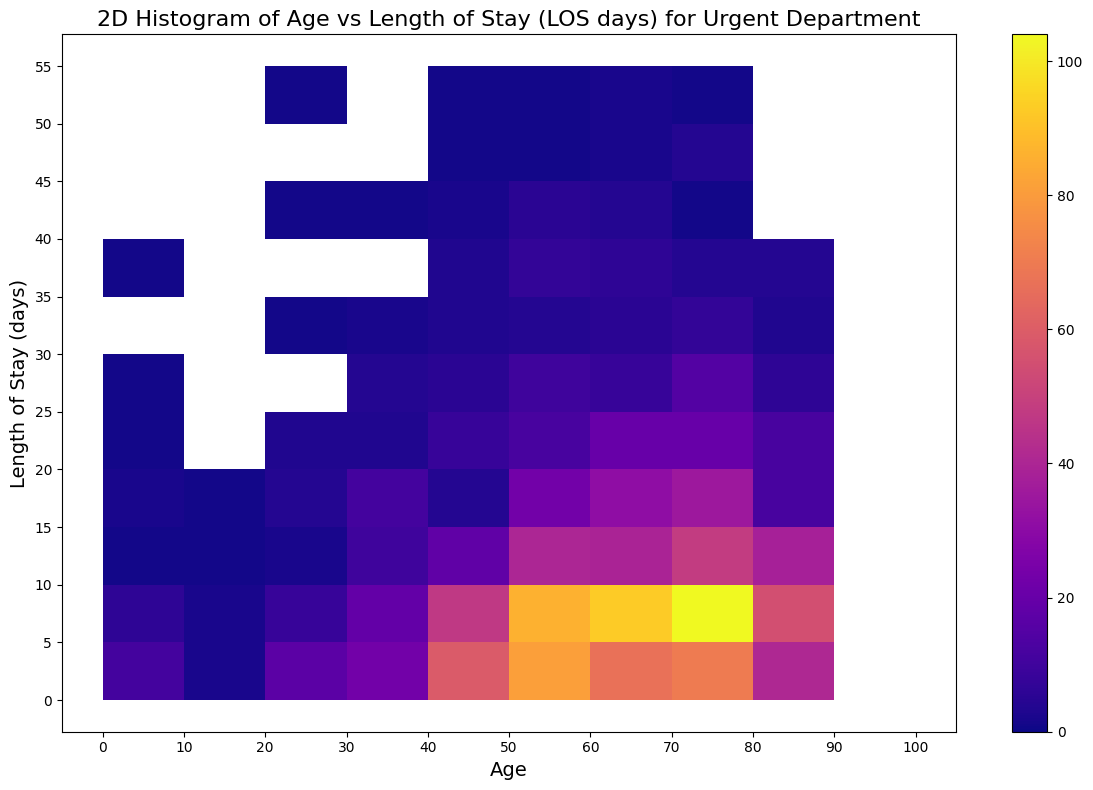

In [ ]:
# Filter data for Emergency Department
emergency_urgent_data = df_mimic[df_mimic['admit_type'] == 'URGENT']

# Create the histogram for Age vs LOS days
plt.figure(figsize=(12, 8))
sns.histplot(data=emergency_urgent_data, x='age', y='LOSdays',
             bins=[range(0, 101, 10), np.arange(0, 56, 5)],
             cbar=True, cmap='plasma')

# Add labels and title
plt.title('2D Histogram of Age vs Length of Stay (LOS days) for Urgent Department', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Length of Stay (days)', fontsize=14)

# Set y-ticks with more space between them
plt.yticks(range(0, 56, 5))

plt.xticks(range(0, 101, 10))  # Keep x-axis ticks at 10-year intervals
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
# Define a specific cardiovascular event
cardio_event = 'CORONARY ARTERY DISEASE'

# Filter female patients with the specific cardiovascular event
female_cardio_patients = df_mimic[(df_mimic['gender'] == 'F') &
                                   (df_mimic['AdmitDiagnosis'] == cardio_event)]

# Create age groups
bins = [0, 18, 35, 50, 65, 80, 100]
labels = ['0-18', '19-35', '36-50', '51-65', '66-80', '81-100']
female_cardio_patients['age_group'] = pd.cut(female_cardio_patients['age'], bins=bins, labels=labels)

# Get the count of patients in each age group
age_group_counts = female_cardio_patients['age_group'].value_counts().sort_index()

# Count of female patients
num_female_patients = female_cardio_patients.shape[0]

print(f"Number of female patients visiting emergency department for {cardio_event}: {num_female_patients}")
print("Age group counts of female patients:")
print(age_group_counts)


Number of female patients visiting emergency department for CORONARY ARTERY DISEASE: 227
Age group counts of female patients:
age_group
0-18        0
19-35       1
36-50       9
51-65      64
66-80     105
81-100     48
Name: count, dtype: int64


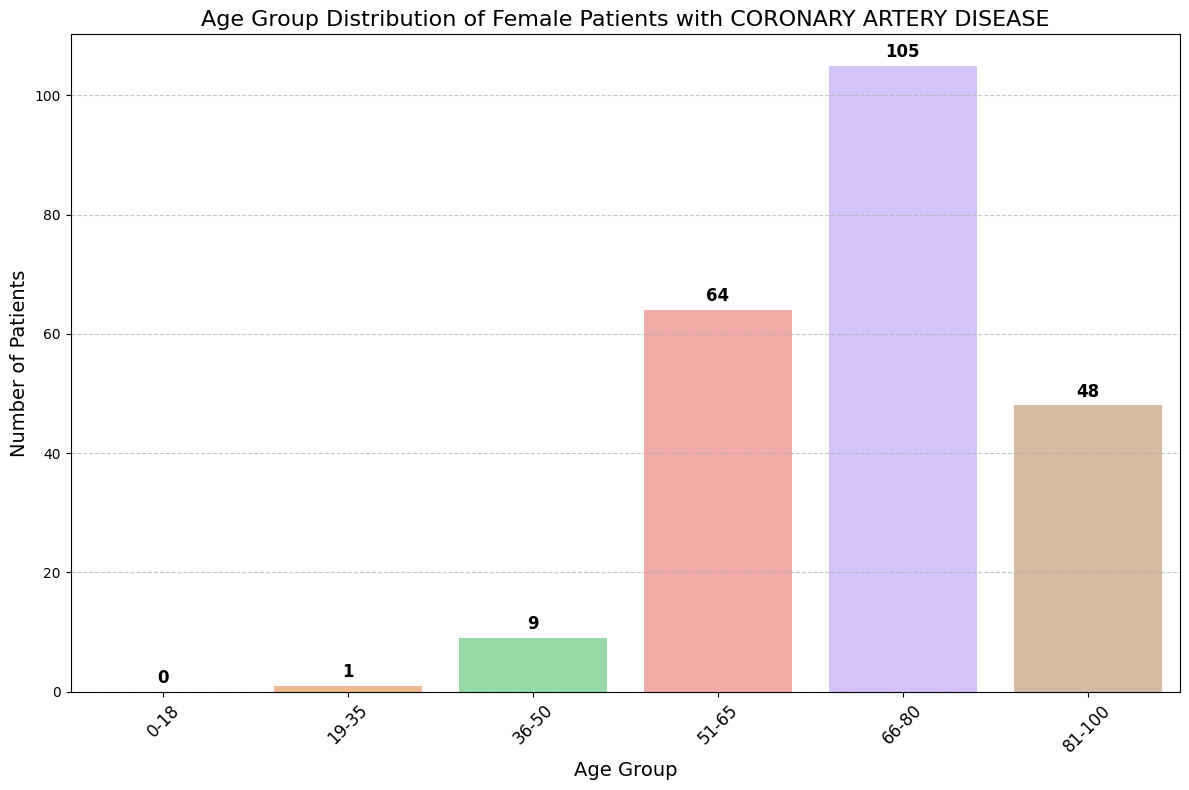

In [ ]:
plt.figure(figsize=(12, 8))  # Set the figure size to be larger

# Plotting the bar chart
ax = sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette='pastel')

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=12, weight='bold')

# Add titles and labels
plt.title(f'Age Group Distribution of Female Patients with {cardio_event}', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Number of Patients', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

# Add gridlines for the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [ ]:
# Filter data for emergency department admissions
emergency_data = df_mimic[df_mimic['admit_type'] == 'EMERGENCY']

# average length of stay for each event
los_by_event = emergency_data.groupby('AdmitDiagnosis')['LOSdays'].mean().reset_index()

# Sort the results to find the event with maximum length of stay
los_by_event = los_by_event.sort_values(by='LOSdays', ascending=False)

# Print the event with the maximum length of stay
max_los_event = los_by_event.iloc[0]
print(f"The event with the maximum length of stay is '{max_los_event['AdmitDiagnosis']}' with an average of {max_los_event['LOSdays']:.2f} days.")

The event with the maximum length of stay is 'L THIGH FLUID COLLECTION' with an average of 166.88 days.


In [ ]:
#Unique values in AdmitDiagnosis variable
df_mimic['AdmitDiagnosis'].nunique()

15682

In [ ]:
df_mimic.head()

,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,ethnicity,...,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum,intime,outtime,arrival_transport
0,F,35,6.17,EMERGENCY,CLINIC REFERRAL/PREMATURE,DIABETIC KETOACIDOSIS,Private,PROTESTANT QUAKER,DIVORCED,WHITE,...,14.91,1.13,0.65,398.70,0,493.89,1,2023-10-19 21:17:16,2023-10-26 01:22:04,WALK IN
1,M,59,4.04,EMERGENCY,EMERGENCY ROOM ADMIT,UPPER GI BLEED,Private,NOT SPECIFIED,SINGLE,WHITE,...,7.18,0.99,1.24,373.02,0,465.71,1,2023-07-29 15:21:50,2023-08-02 16:19:26,AMBULANCE
2,F,48,12.04,EMERGENCY,EMERGENCY ROOM ADMIT,COPD FLARE,Private,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,...,6.23,0.00,0.33,286.21,0,344.00,3,2023-10-21 08:38:02,2023-11-02 09:35:38,AMBULANCE
3,F,73,7.29,EMERGENCY,EMERGENCY ROOM ADMIT,BOWEL OBSTRUCTION,Private,JEWISH,MARRIED,WHITE,...,11.52,0.00,0.96,526.06,0,603.05,1,2023-12-01 05:23:19,2023-12-08 12:20:55,AMBULANCE
4,M,60,4.88,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,CORONARY ARTERY DISEASE,Private,CATHOLIC,MARRIED,WHITE,...,25.00,2.87,2.05,554.92,0,679.84,1,2022-09-02 00:03:08,2022-09-06 21:10:20,WALK IN


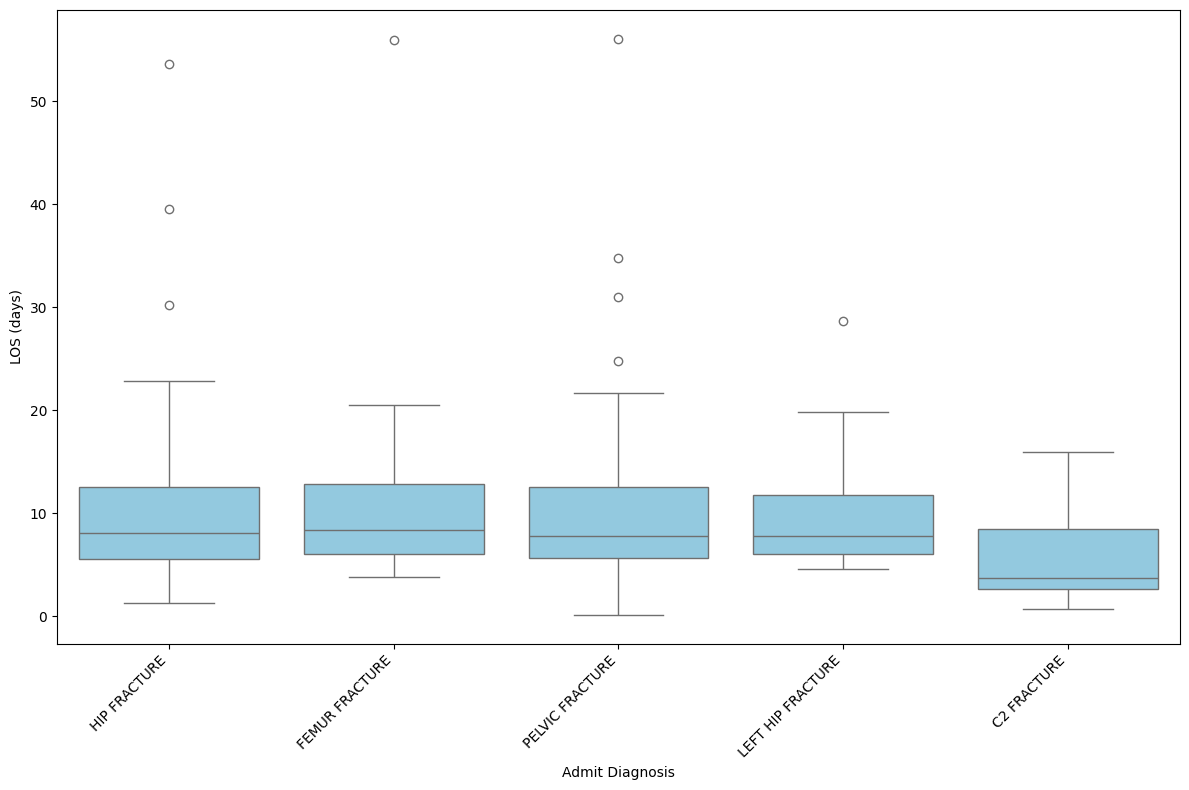

In [ ]:
#Top 5 fracture related column boxplot
fracture_keywords = ['FRACTURE', 'HIP FRACTURE']
df_fractures = df_mimic[df_mimic['AdmitDiagnosis'].str.contains('|'.join(fracture_keywords), case=False, na=False)]

top_fractures = df_fractures['AdmitDiagnosis'].value_counts().nlargest(5).index

df_top_fractures = df_fractures[df_fractures['AdmitDiagnosis'].isin(top_fractures)]

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_top_fractures, x='AdmitDiagnosis', y='LOSdays', color='skyblue')

plt.xlabel('Admit Diagnosis')
plt.ylabel('LOS (days)')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

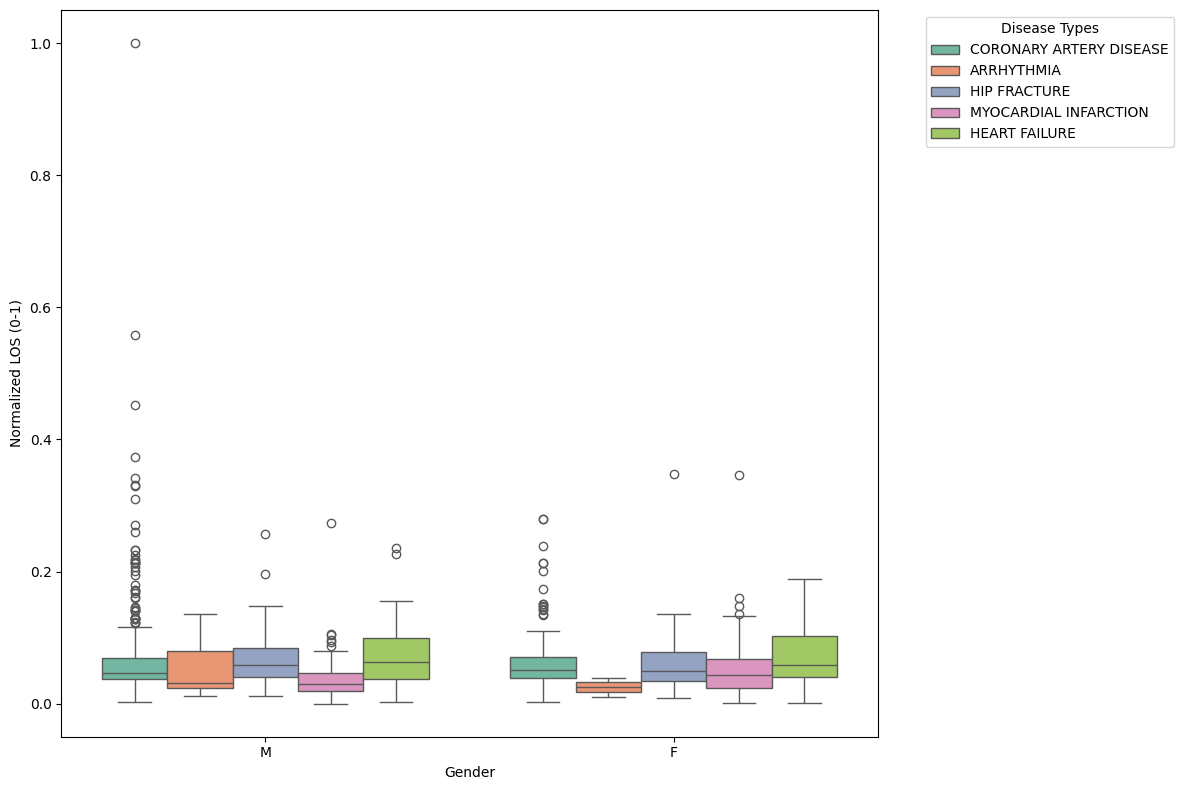

In [ ]:
#Boxplot for Gender and LOS
from sklearn.preprocessing import MinMaxScaler
diseases_of_interest = [
    'CORONARY ARTERY DISEASE',
    'HEART FAILURE',
    'MYOCARDIAL INFARCTION',
    'ARRHYTHMIA',
    'HIP FRACTURE'
]

filtered_data = df_mimic[df_mimic['AdmitDiagnosis'].isin(diseases_of_interest)]

scaler = MinMaxScaler()
filtered_data['LOSdays_normalized'] = scaler.fit_transform(filtered_data[['LOSdays']])

# Plotting
plt.figure(figsize=(12, 8))
sns.boxplot(
    x='gender',
    y='LOSdays_normalized',
    hue='AdmitDiagnosis',
    data=filtered_data,
    palette='Set2'
)

plt.xlabel('Gender')
plt.ylabel('Normalized LOS (0-1)')
plt.legend(title='Disease Types', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [ ]:
# Define hip fracture condition
hip_fracture_condition = 'HIP FRACTURE'

# Filter data for emergency department and hip fracture
hip_fracture_data = df_mimic[(df_mimic['admit_type'] == 'EMERGENCY') & (df_mimic['AdmitDiagnosis'] == hip_fracture_condition)]

# Calculate average length of stay
average_los_hip_fracture = hip_fracture_data['LOSdays'].mean()

print(f"The average length of stay for patients visiting the emergency department for hip fracture treatment is {average_los_hip_fracture:.2f} days.")


The average length of stay for patients visiting the emergency department for hip fracture treatment is 10.32 days.


In [ ]:
# Filter for fracture categories
fracture_data = df_mimic[df_mimic['AdmitDiagnosis'].str.contains('FRACTURE', na=False)]
fracture_data['AdmitDiagnosis'].value_counts()[:10]

,count
AdmitDiagnosis,
HIP FRACTURE,67
PELVIC FRACTURE,36
FEMUR FRACTURE,28
LEFT HIP FRACTURE,17
C2 FRACTURE,17
RIGHT HIP FRACTURE,14
SKULL FRACTURE,13
CERVICAL SPINE FRACTURE,10
C1 FRACTURE,10


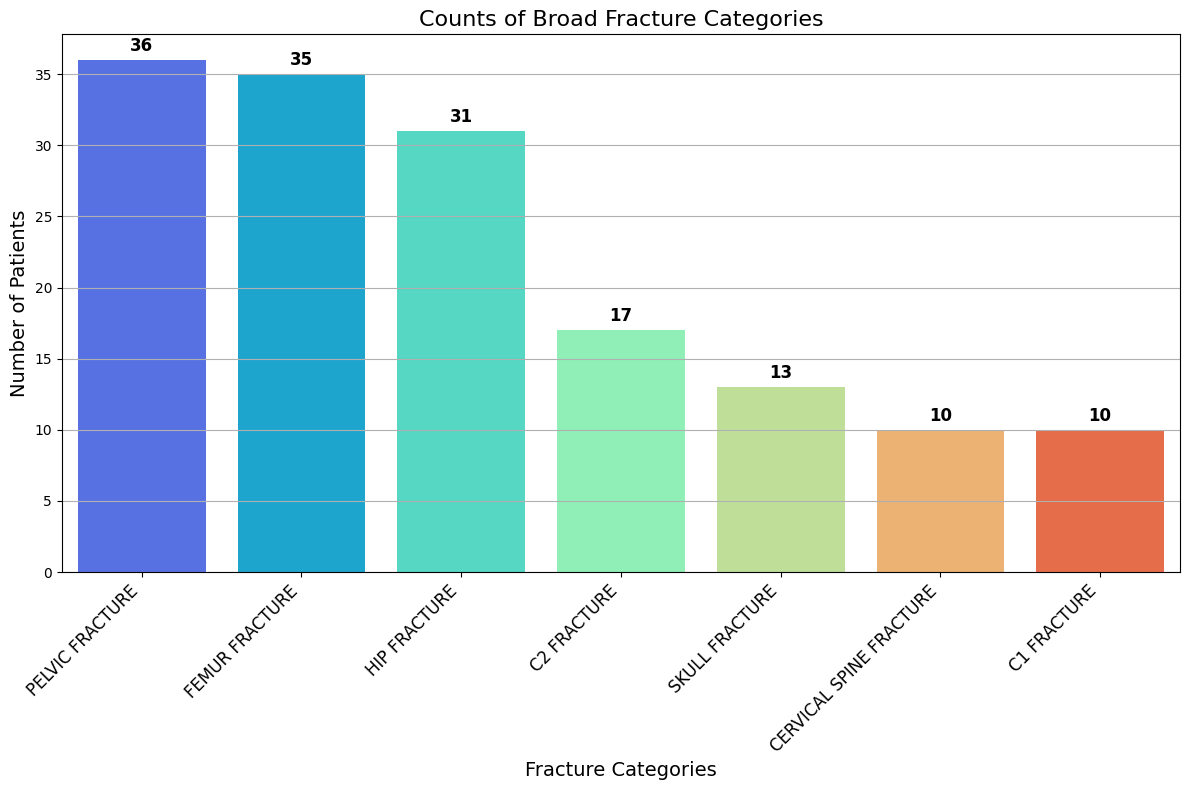

In [ ]:
# Define mapping for fracture categories
category_mapping = {
    'LEFT HIP FRACTURE': 'HIP FRACTURE',
    'RIGHT HIP FRACTURE': 'HIP FRACTURE',
    'FEMUR FRACTURE': 'FEMUR FRACTURE',
    'LEFT FEMUR FRACTURE': 'FEMUR FRACTURE',
    'PELVIC FRACTURE': 'PELVIC FRACTURE',
    'SKULL FRACTURE': 'SKULL FRACTURE',
    'CERVICAL SPINE FRACTURE': 'CERVICAL SPINE FRACTURE',
    'C1 FRACTURE': 'C1 FRACTURE',
    'C2 FRACTURE': 'C2 FRACTURE'
}

# Apply mapping to create broader categories
df_mimic['BroadFractureCategory'] = df_mimic['AdmitDiagnosis'].map(category_mapping)

# Filter for fracture categories
fracture_data = df_mimic[df_mimic['BroadFractureCategory'].str.contains('FRACTURE', na=False)]

# Count of each broad fracture category
fracture_counts = fracture_data['BroadFractureCategory'].value_counts()

# Create a bar plot for broad fracture categories
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=fracture_counts.index, y=fracture_counts.values, palette='rainbow')

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=12, weight='bold')

# Add titles and labels
plt.title('Counts of Broad Fracture Categories', fontsize=16)
plt.xlabel('Fracture Categories', fontsize=14)
plt.ylabel('Number of Patients', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add gridlines for the y-axis
plt.grid(axis='y')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [ ]:
# Filter for HIP Fracture cases
HIP_Fracture_Df = df_mimic[df_mimic['AdmitDiagnosis'].str.contains('HIP FRACTURE', na=False)]

# Convert 'intime' to datetime
HIP_Fracture_Df['intime'] = pd.to_datetime(HIP_Fracture_Df['intime'])

# Extract year, month, quarter, and day
HIP_Fracture_Df['Year'] = HIP_Fracture_Df['intime'].dt.year
HIP_Fracture_Df['Month'] = HIP_Fracture_Df['intime'].dt.month
HIP_Fracture_Df['Quarter'] = HIP_Fracture_Df['intime'].dt.to_period('Q').astype(str)
HIP_Fracture_Df['Day'] = HIP_Fracture_Df['intime'].dt.day

# Count number of patients per month
monthly_counts = HIP_Fracture_Df.groupby(['Year', 'Month'])['AdmitDiagnosis'].count().reset_index(name='Number of Patients')
monthly_counts['Period'] = monthly_counts['Year'].astype(str) + '-' + monthly_counts['Month'].astype(str).str.zfill(2)

# Count number of patients per quarter
quarterly_counts = HIP_Fracture_Df.groupby(['Year', 'Quarter'])['AdmitDiagnosis'].count().reset_index(name='Number of Patients')
quarterly_counts['Period'] = quarterly_counts['Quarter']

# Count number of patients per day
daily_counts = HIP_Fracture_Df.groupby(['Year', 'Month', 'Day'])['AdmitDiagnosis'].count().reset_index(name='Number of Patients')
daily_counts['Period'] = daily_counts['Year'].astype(str) + '-' + daily_counts['Month'].astype(str).str.zfill(2) + '-' + daily_counts['Day'].astype(str).str.zfill(2)

# Determine the max y-axis value for consistent scaling
max_y = max(monthly_counts['Number of Patients'].max(),
             quarterly_counts['Number of Patients'].max(),
             daily_counts['Number of Patients'].max())

In [ ]:
# Reformat the Period for quarterly counts to ensure it's in a consistent string format
quarterly_counts['Period'] = quarterly_counts['Year'].astype(str) + ' ' + quarterly_counts['Quarter']

In [ ]:
!pip install plotly
import plotly.graph_objects as go
# Recreate the figure from scratch to avoid any hidden states
fig = go.Figure()

# Add quartely data trace (index 0)
fig.add_trace(go.Scatter(x=quarterly_counts['Period'], y=quarterly_counts['Number of Patients'],
                         mode='lines+markers', name='Quarterly'))
# Add monthly data trace (index 1)
fig.add_trace(go.Scatter(x=monthly_counts['Period'], y=monthly_counts['Number of Patients'],
                         mode='lines+markers', name='Monthly'))
# Add daily data trace (index 2)
fig.add_trace(go.Scatter(x=daily_counts['Period'], y=daily_counts['Number of Patients'],
                         mode='lines+markers', name='Daily'))

# Update layout with dropdown menu
fig.update_layout(
    title='HIP Fracture Cases by Time Period',
    xaxis_title='Time Period',
    yaxis_title='Number of Patients',
    yaxis=dict(range=[0, max_y]),  # Consistent y-axis scaling
    updatemenus=[{
        'buttons': [
            {'label': 'Quarterly View', 'method': 'update', 'args': [{'visible': [True, False, False]}, {'title': 'Quarterly HIP Fracture Cases'}]},
            {'label': 'Monthly View', 'method': 'update', 'args': [{'visible': [False, True, False]}, {'title': 'Monthly HIP Fracture Cases'}]},
            {'label': 'Daily View', 'method': 'update', 'args': [{'visible': [False, False, True]}, {'title': 'Daily HIP Fracture Cases'}]},
        ],
        'direction': 'down',
        'showactive': True,
    }]
)

# Set default visibility
fig.data[0].visible = True  # Monthly
fig.data[1].visible = False  # Quarterly
fig.data[2].visible = False  # Daily

# Debugging: Print visibility status to ensure indices are correct
print([trace.visible for trace in fig.data])

# Show the figure
fig.show()

[True, False, False]


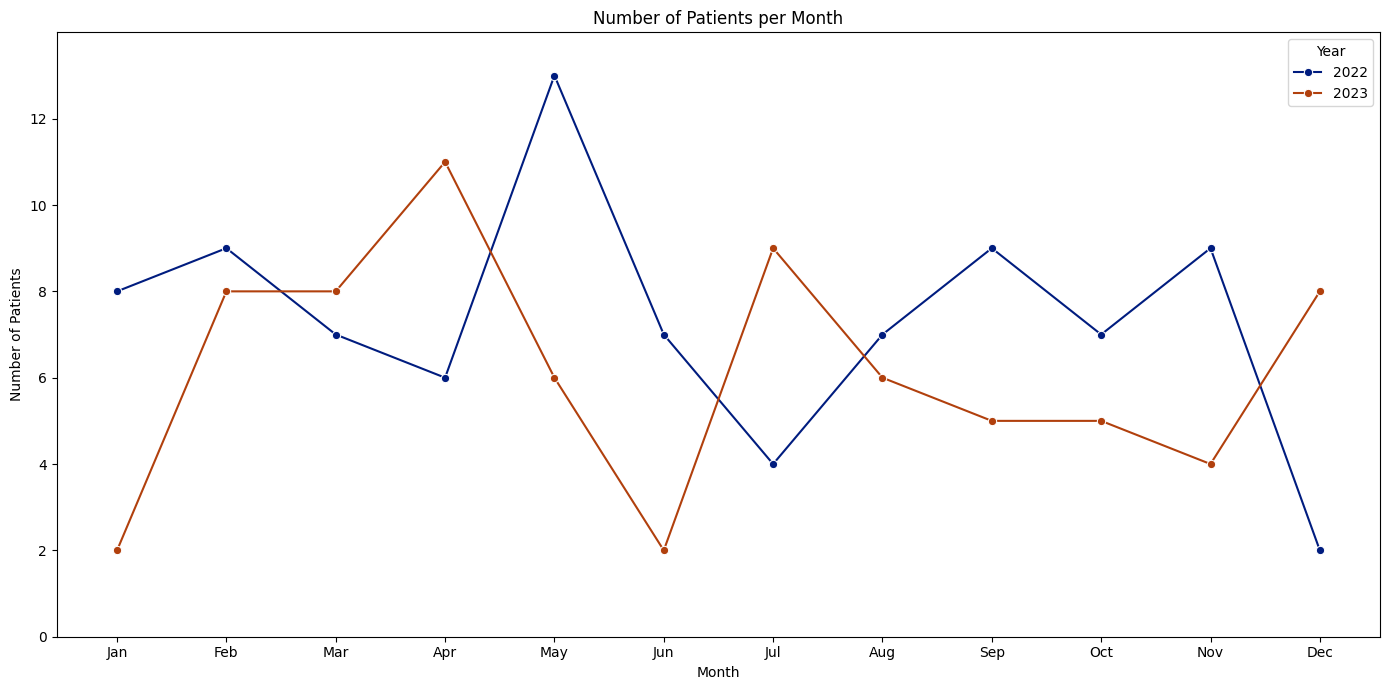

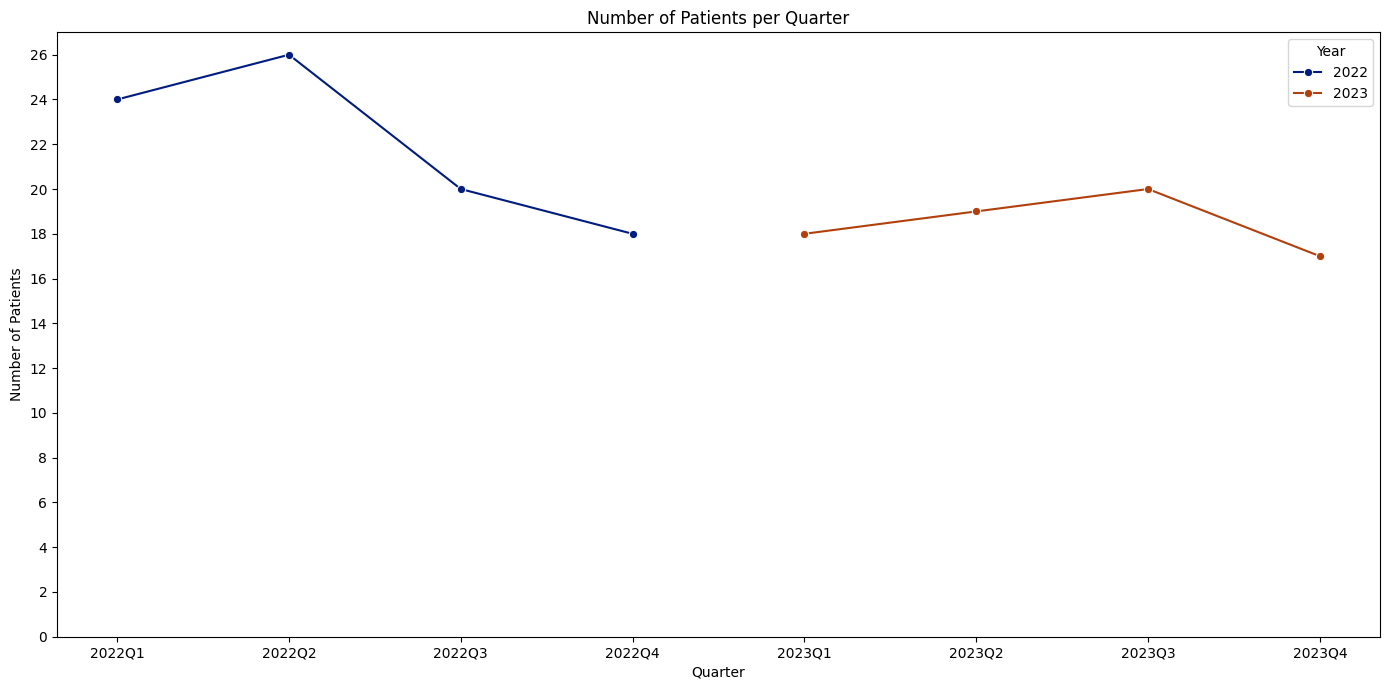

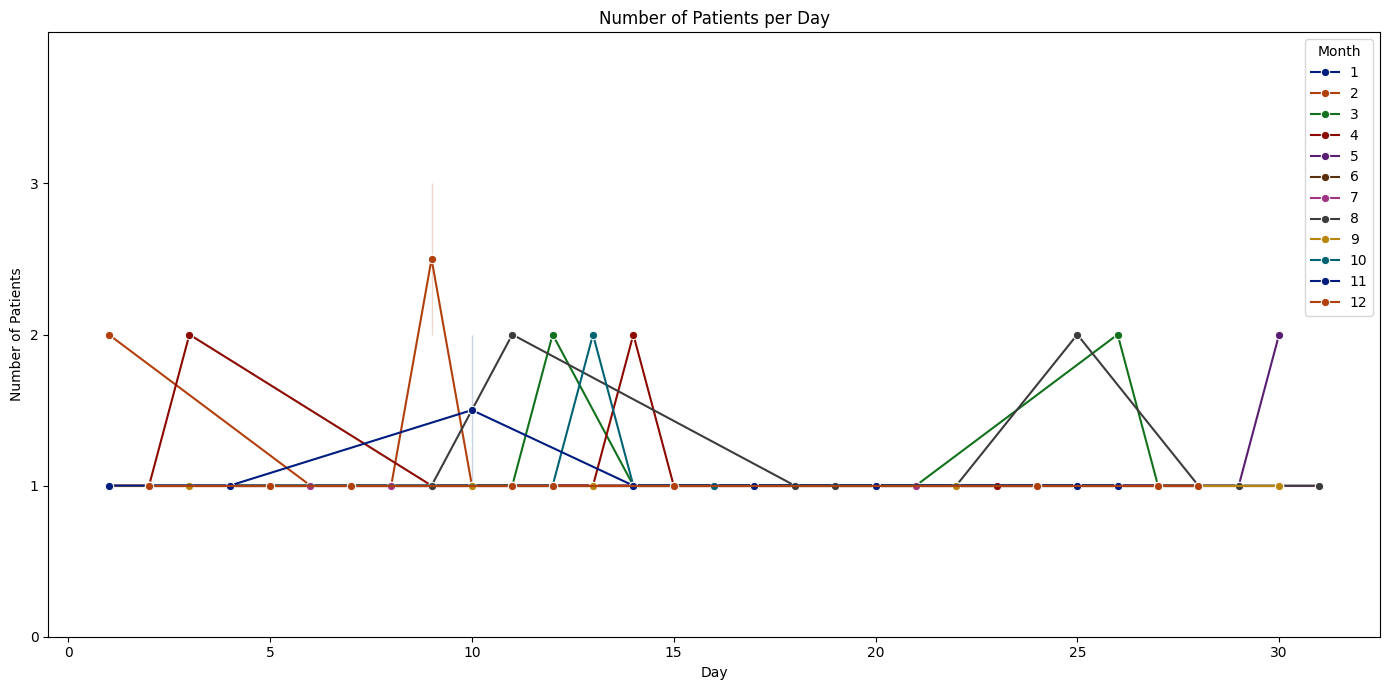

In [ ]:
# Filter for HIP Fracture cases
HIP_Fracture_Df = df_mimic[df_mimic['AdmitDiagnosis'].str.contains('HIP FRACTURE', na=False)]

# Convert 'intime' to datetime
HIP_Fracture_Df['intime'] = pd.to_datetime(HIP_Fracture_Df['intime'])

# Extract year, month, quarter, and day
HIP_Fracture_Df['Year'] = HIP_Fracture_Df['intime'].dt.year
HIP_Fracture_Df['Month'] = HIP_Fracture_Df['intime'].dt.month
HIP_Fracture_Df['Quarter'] = HIP_Fracture_Df['intime'].dt.to_period('Q').astype(str)
HIP_Fracture_Df['Day'] = HIP_Fracture_Df['intime'].dt.day

# Count number of patients per month
monthly_counts = HIP_Fracture_Df.groupby(['Year', 'Month'])['AdmitDiagnosis'].count().reset_index(name='Number of Patients')
monthly_counts['Period'] = monthly_counts['Year'].astype(str) + '-' + monthly_counts['Month'].astype(str).str.zfill(2)

# Count number of patients per quarter
quarterly_counts = HIP_Fracture_Df.groupby(['Year', 'Quarter'])['AdmitDiagnosis'].count().reset_index(name='Number of Patients')
quarterly_counts['Period'] = quarterly_counts['Quarter']

# Count number of patients per day
daily_counts = HIP_Fracture_Df.groupby(['Year', 'Month', 'Day'])['AdmitDiagnosis'].count().reset_index(name='Number of Patients')
daily_counts['Period'] = daily_counts['Year'].astype(str) + '-' + daily_counts['Month'].astype(str).str.zfill(2) + '-' + daily_counts['Day'].astype(str).str.zfill(2)

# Determine the max y-axis value for consistent scaling
max_y = max(monthly_counts['Number of Patients'].max(),
             quarterly_counts['Number of Patients'].max(),
             daily_counts['Number of Patients'].max())

# Plot for monthly counts
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_counts, x='Month', y='Number of Patients', hue='Year', marker='o', palette='dark')
plt.title('Number of Patients per Month')
plt.xlabel('Month')
plt.ylabel('Number of Patients')
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylim(0, monthly_counts['Number of Patients'].max() + 1)
# Set y-axis ticks with a difference of 2 without y_max
plt.yticks(np.arange(0, monthly_counts['Number of Patients'].max() + 1, 2))

plt.grid(False)  # Remove grid lines
plt.tight_layout()
plt.show()

# Plot for quarterly counts
plt.figure(figsize=(14, 7))
sns.lineplot(data=quarterly_counts, x='Quarter', y='Number of Patients', hue='Year', marker='o', palette='dark')
plt.title('Number of Patients per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Number of Patients')
plt.ylim(0, quarterly_counts['Number of Patients'].max() + 1)
# Set y-axis ticks with a difference of 2 without y_max
plt.yticks(np.arange(0, quarterly_counts['Number of Patients'].max() + 1, 2))

plt.grid(False)  # Remove grid lines
plt.tight_layout()
plt.show()

# Plot for daily counts
plt.figure(figsize=(14, 7))
sns.lineplot(data=daily_counts, x='Day', y='Number of Patients', hue='Month', marker='o', palette='dark')
plt.title('Number of Patients per Day')
plt.xlabel('Day')
plt.ylabel('Number of Patients')
plt.ylim(0,daily_counts['Number of Patients'].max() + 1 )

# Set y-axis ticks with a difference of 2
#plt.yticks(np.arange(0, max_y + 1, 2))

# Set y-axis ticks with a difference of 2 without y_max
plt.yticks(np.arange(0, daily_counts['Number of Patients'].max() + 1, 1))

plt.grid(False)  # Remove grid lines
plt.tight_layout()
plt.show()

In [ ]:
# Define hip fracture condition
hip_fracture_condition = 'HIP FRACTURE'

# Filter data for emergency department and hip fracture
hip_fracture_data = df_mimic[(df_mimic['admit_type'] == 'EMERGENCY') & (df_mimic['AdmitDiagnosis'] == hip_fracture_condition)]

# Count the number of males and females
gender_counts = hip_fracture_data['gender'].value_counts()

print(f"Total number of males visiting the emergency department for hip fracture: {gender_counts.get('M', 0)}")
print(f"Total number of females visiting the emergency department for hip fracture: {gender_counts.get('F', 0)}")


Total number of males visiting the emergency department for hip fracture: 28
Total number of females visiting the emergency department for hip fracture: 39


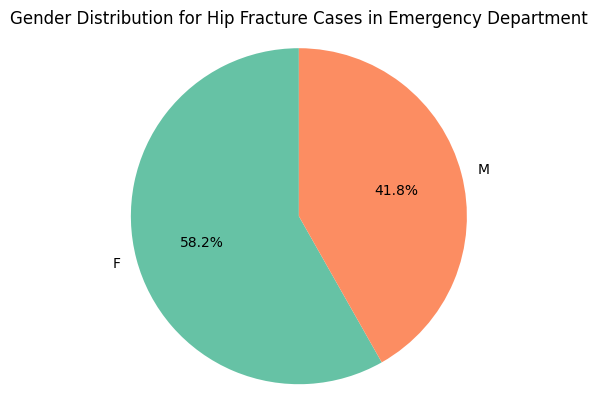

In [ ]:
# Pie Chart
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
plt.title('Gender Distribution for Hip Fracture Cases in Emergency Department')
plt.axis('equal')
plt.show()

In [ ]:
# Create age groups
bins = [0, 18, 30, 45, 60, 75, 90, 100]
labels = ['0-18', '19-30', '31-45', '46-60', '61-75', '76-90', '91+']
hip_fracture_data['AgeGroup'] = pd.cut(hip_fracture_data['age'], bins=bins, labels=labels)

# Count the occurrences of each age group
age_group_counts = hip_fracture_data['AgeGroup'].value_counts()

print("Age group counts for hip fractures:")
print(age_group_counts)

Age group counts for hip fractures:
AgeGroup
76-90    32
46-60    19
61-75    13
31-45     3
0-18      0
19-30     0
91+       0
Name: count, dtype: int64


<Figure size 1400x1000 with 0 Axes>

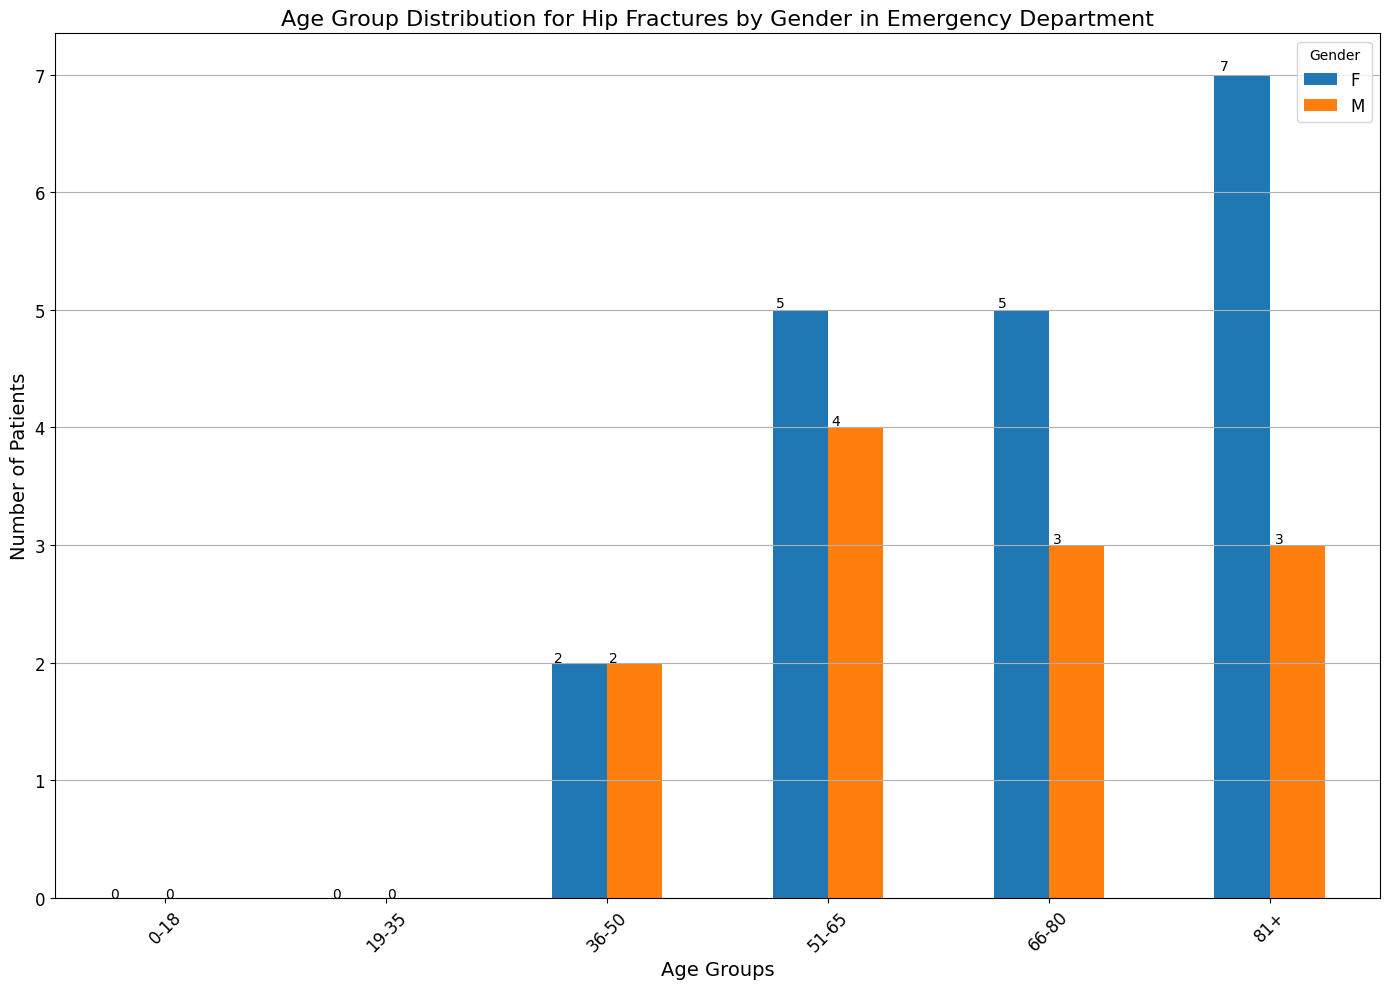

In [ ]:
df_mimic['age_group'] = pd.cut(df_mimic['age'], bins=[0, 18, 35, 50, 65, 80, 100], labels=['0-18', '19-35', '36-50', '51-65', '66-80', '81+'])

# Filter for hip fractures
hip_fracture_data = df_mimic[df_mimic['BroadFractureCategory'] == 'HIP FRACTURE']

# Count of patients per age group and gender
age_gender_counts = hip_fracture_data.groupby(['age_group', 'gender']).size().unstack().fillna(0)

plt.figure(figsize=(14, 10))  # Increase the size as per your preference

# Plot the grouped bar chart
ax = age_gender_counts.plot(kind='bar', stacked=False, color=['#1f77b4', '#ff7f0e'], figsize=(14, 10))  # Increase figsize here

# Add counts on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=10)

# Customize the chart further
plt.title('Age Group Distribution for Hip Fractures by Gender in Emergency Department', fontsize=16)
plt.xlabel('Age Groups', fontsize=14)
plt.ylabel('Number of Patients', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Gender', fontsize=12)
plt.grid(axis='y')
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Define hip fracture condition
hip_fracture_condition = 'HIP FRACTURE'

# Filter data for emergency department and hip fracture
hip_fracture_data = df_mimic[(df_mimic['admit_type'] == 'EMERGENCY') & (df_mimic['AdmitDiagnosis'] == hip_fracture_condition)]

# Get the counts of each mode of transport for patients with hip fractures
transport_counts = hip_fracture_data['arrival_transport'].value_counts()

# Print the mode of transport
mode_transport = hip_fracture_data['arrival_transport'].mode()[0]
print(f"The mode of transport for patients visiting the emergency department for hip fractures is: {mode_transport}")

The mode of transport for patients visiting the emergency department for hip fractures is: WALK IN


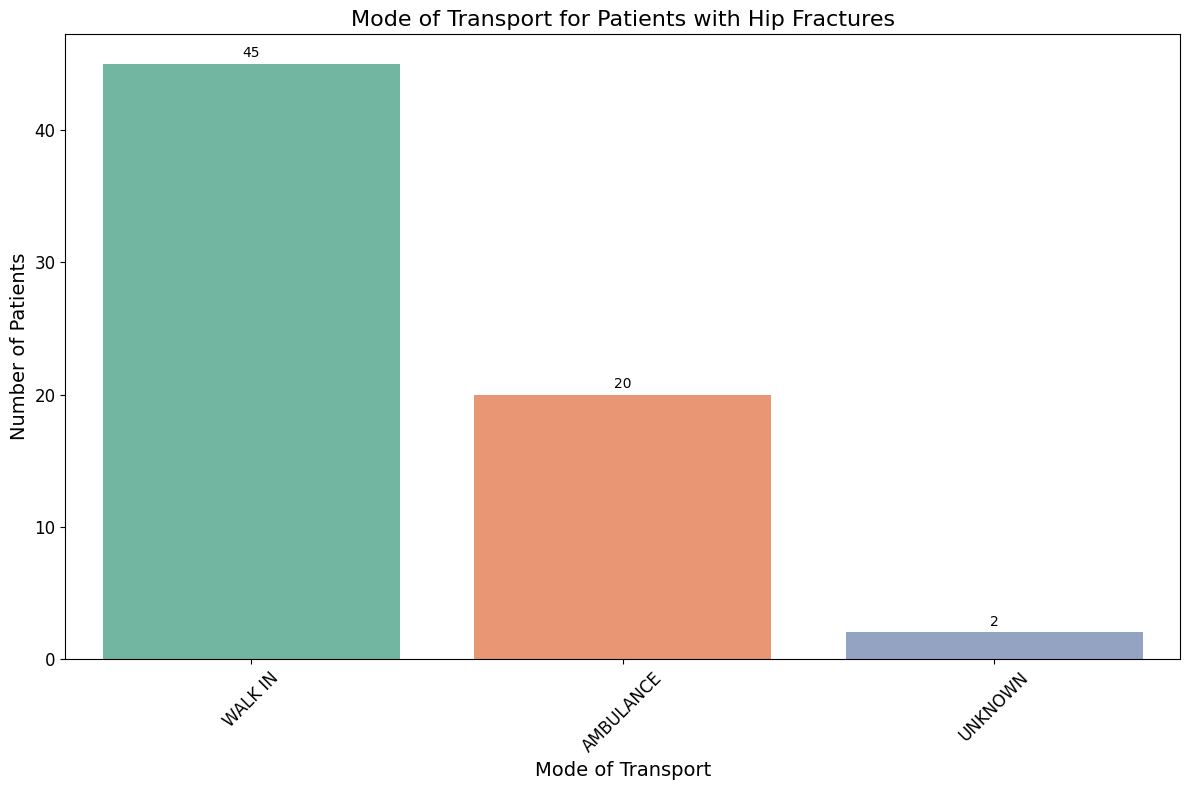

In [ ]:
plt.figure(figsize=(12, 8))

# Create the bar plot
ax = sns.barplot(x=transport_counts.index, y=transport_counts.values, palette='Set2')

# Add counts on top of each bar
for i in range(len(transport_counts)):
    ax.text(i, transport_counts.values[i] + 0.5, f'{transport_counts.values[i]}', ha='center', fontsize=10)

# Customize the chart
plt.title('Mode of Transport for Patients with Hip Fractures', fontsize=16)
plt.xlabel('Mode of Transport', fontsize=14)
plt.ylabel('Number of Patients', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

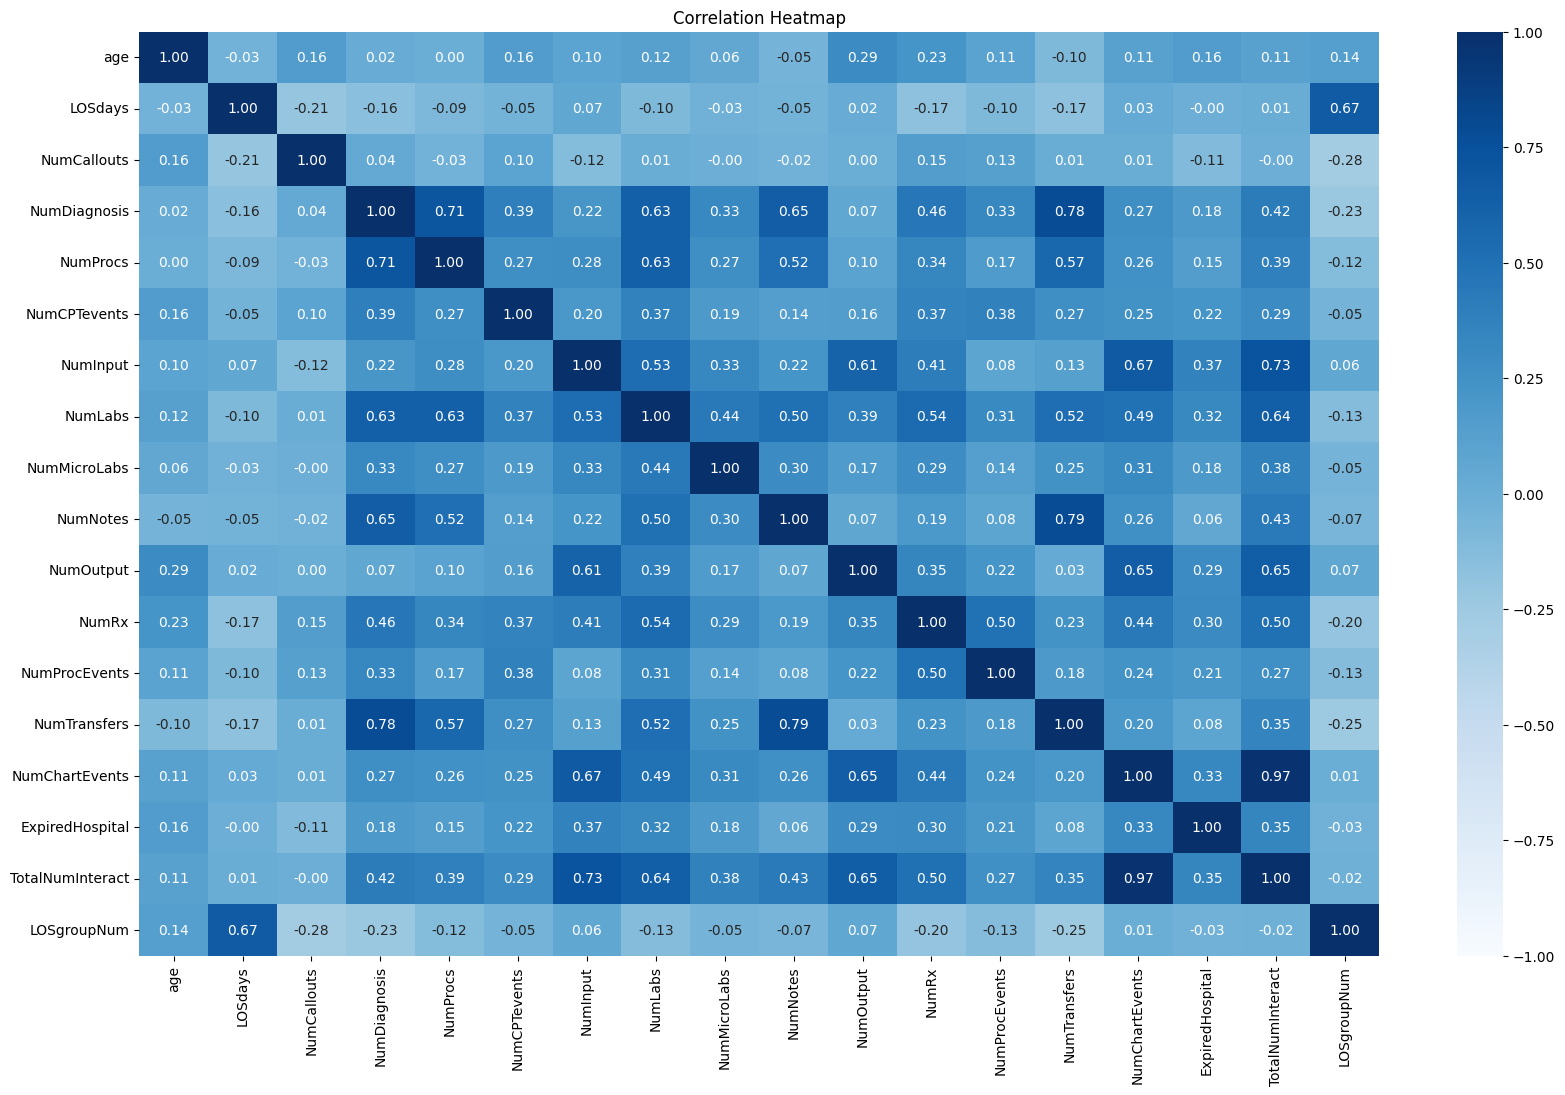

In [ ]:
#Heatmap
numerical_columns = df_mimic.select_dtypes(include=['int64', 'float64']).columns

# Create a heatmap of correlations between numerical features and LOSdays
plt.figure(figsize=(20, 12))
sns.heatmap(df_mimic[numerical_columns].corr(), annot=True, cmap='Blues', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Perform label encoding
label_encoder = LabelEncoder()
df_mimic['gender'] = label_encoder.fit_transform(df_mimic['gender'])
df_mimic['admit_type'] = label_encoder.fit_transform(df_mimic['admit_type'])
df_mimic['admit_location'] = label_encoder.fit_transform(df_mimic['admit_location'])
df_mimic['AdmitDiagnosis'] = label_encoder.fit_transform(df_mimic['AdmitDiagnosis'])
df_mimic['insurance'] = label_encoder.fit_transform(df_mimic['insurance'])
df_mimic['religion'] = label_encoder.fit_transform(df_mimic['religion'])
df_mimic['marital_status'] = label_encoder.fit_transform(df_mimic['marital_status'])
df_mimic['arrival_transport'] = label_encoder.fit_transform(df_mimic['arrival_transport'])
df_mimic['ethnicity'] = label_encoder.fit_transform(df_mimic['ethnicity'])
df_mimic['AdmitProcedure'] = label_encoder.fit_transform(df_mimic['AdmitProcedure'])

In [ ]:
df_mimic.head()

,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,ethnicity,...,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum,intime,outtime,arrival_transport,BroadFractureCategory,age_group
0,0,35,6.17,1,1,5169,3,16,0,36,...,0.65,398.70,0,493.89,1,2023-10-19 21:17:16,2023-10-26 01:22:04,4,NaN,19-35
1,1,59,4.04,1,2,15267,3,14,4,36,...,1.24,373.02,0,465.71,1,2023-07-29 15:21:50,2023-08-02 16:19:26,0,NaN,51-65
2,0,48,12.04,1,2,4327,3,14,4,13,...,0.33,286.21,0,344.00,3,2023-10-21 08:38:02,2023-11-02 09:35:38,0,NaN,36-50
3,0,73,7.29,1,2,2469,3,10,2,36,...,0.96,526.06,0,603.05,1,2023-12-01 05:23:19,2023-12-08 12:20:55,0,NaN,66-80
4,1,60,4.88,1,5,4367,3,3,2,36,...,2.05,554.92,0,679.84,1,2022-09-02 00:03:08,2022-09-06 21:10:20,4,NaN,51-65


In [ ]:
df_mimic.drop(['intime', 'outtime' ], axis=1, inplace=True)

In [ ]:
df = df_mimic.drop(['AdmitDiagnosis','BroadFractureCategory','age_group','ExpiredHospital', 'AdmitProcedure', 'marital_status', 'ethnicity', 'religion','insurance'], axis=1)

# Verify the columns in df
print(df.columns)


Index(['gender', 'age', 'LOSdays', 'admit_type', 'admit_location',
       'NumCallouts', 'NumDiagnosis', 'NumProcs', 'NumCPTevents', 'NumInput',
       'NumLabs', 'NumMicroLabs', 'NumNotes', 'NumOutput', 'NumRx',
       'NumProcEvents', 'NumTransfers', 'NumChartEvents', 'TotalNumInteract',
       'LOSgroupNum', 'arrival_transport'],
      dtype='object')


In [ ]:
#Dimension of dataset
df.shape

(58976, 21)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             58976 non-null  int64  
 1   age                58976 non-null  int64  
 2   LOSdays            58976 non-null  float64
 3   admit_type         58976 non-null  int64  
 4   admit_location     58976 non-null  int64  
 5   NumCallouts        58976 non-null  float64
 6   NumDiagnosis       58976 non-null  float64
 7   NumProcs           58976 non-null  float64
 8   NumCPTevents       58976 non-null  float64
 9   NumInput           58976 non-null  float64
 10  NumLabs            58976 non-null  float64
 11  NumMicroLabs       58976 non-null  float64
 12  NumNotes           58976 non-null  float64
 13  NumOutput          58976 non-null  float64
 14  NumRx              58976 non-null  float64
 15  NumProcEvents      58976 non-null  float64
 16  NumTransfers       589

In [ ]:
X = df.drop('LOSgroupNum', axis=1)
y = df['LOSgroupNum']

print(X.shape, y.shape)

(58976, 20) (58976,)


In [ ]:
X = X.drop('LOSdays', axis=1)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             58976 non-null  int64  
 1   age                58976 non-null  int64  
 2   admit_type         58976 non-null  int64  
 3   admit_location     58976 non-null  int64  
 4   NumCallouts        58976 non-null  float64
 5   NumDiagnosis       58976 non-null  float64
 6   NumProcs           58976 non-null  float64
 7   NumCPTevents       58976 non-null  float64
 8   NumInput           58976 non-null  float64
 9   NumLabs            58976 non-null  float64
 10  NumMicroLabs       58976 non-null  float64
 11  NumNotes           58976 non-null  float64
 12  NumOutput          58976 non-null  float64
 13  NumRx              58976 non-null  float64
 14  NumProcEvents      58976 non-null  float64
 15  NumTransfers       58976 non-null  float64
 16  NumChartEvents     589

In [ ]:
print(df.shape)
print(X.shape)
XnotNorm = X.copy()
print('XnotNorm ', XnotNorm.shape)

ynotNorm = y.copy()
print('ynotNorm ', ynotNorm.shape)

(58976, 21)
(58976, 19)
XnotNorm  (58976, 19)
ynotNorm  (58976,)


In [ ]:
# Normalize X
from sklearn import preprocessing
x = XnotNorm.values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
XNorm = pd.DataFrame(x_scaled, columns=XnotNorm.columns)
#print(XNorm)


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(XNorm , y, test_size=0.2, random_state=42)
print ('X_train: ', X_train.shape)
print ('X_test: ', X_test.shape)
print ('y_train: ', y_train.shape)
print ('y_test: ', y_test.shape)


X_train:  (47180, 19)
X_test:  (11796, 19)
y_train:  (47180,)
y_test:  (11796,)


In [ ]:
# Assuming X_train and y_train are defined and there is a class imbalance
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

##GBM Classifier Model

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Confusion Matrix:
 [[2230 2284    1   94]
 [1431 3238    0   96]
 [ 145  825    0   27]
 [ 215 1072    0  138]]


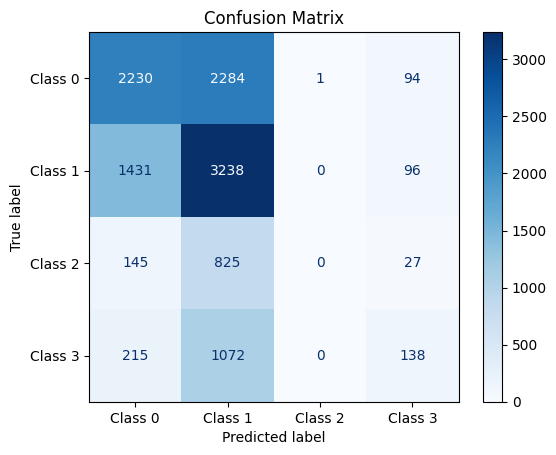

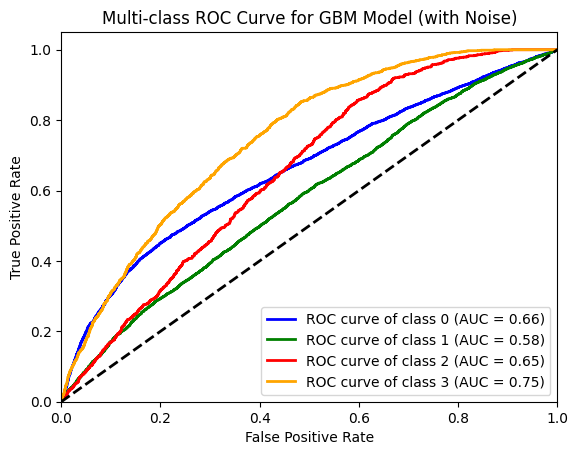

Macro AUC: 0.66
Weighted AUC: 0.64
Accuracy: 0.4752458460495083
Precision: 0.43995518941696277
Recall: 0.4752458460495083
F1-score: 0.43536555467412574
AUC-ROC: 0.6590520333919442
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 50}


PermutationExplainer explainer: 11797it [47:06,  4.16it/s]


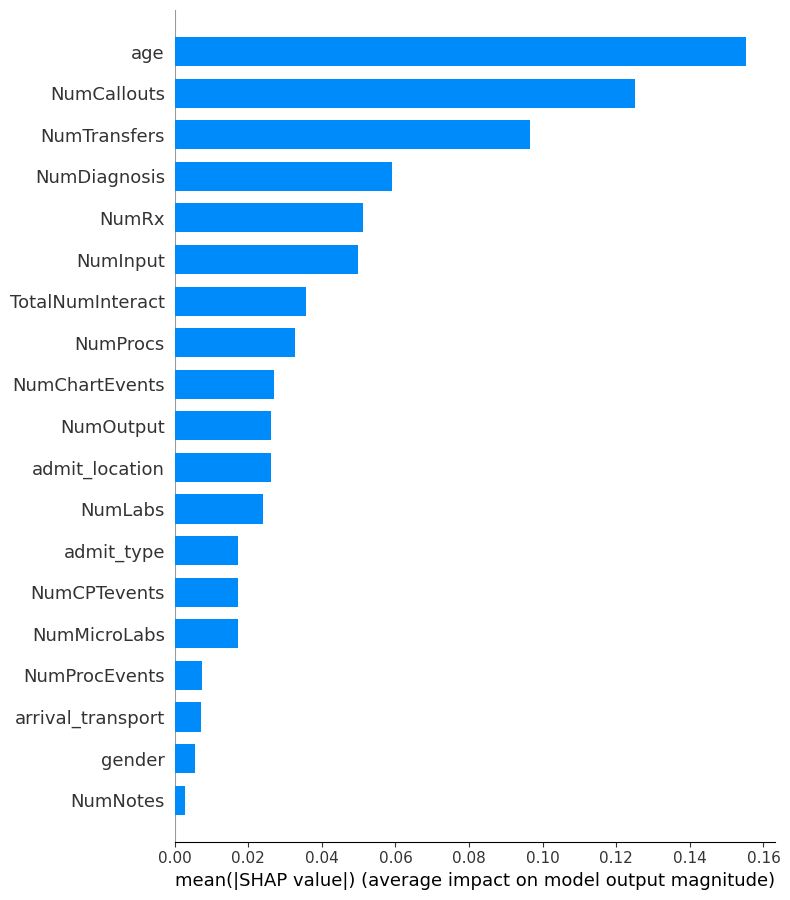

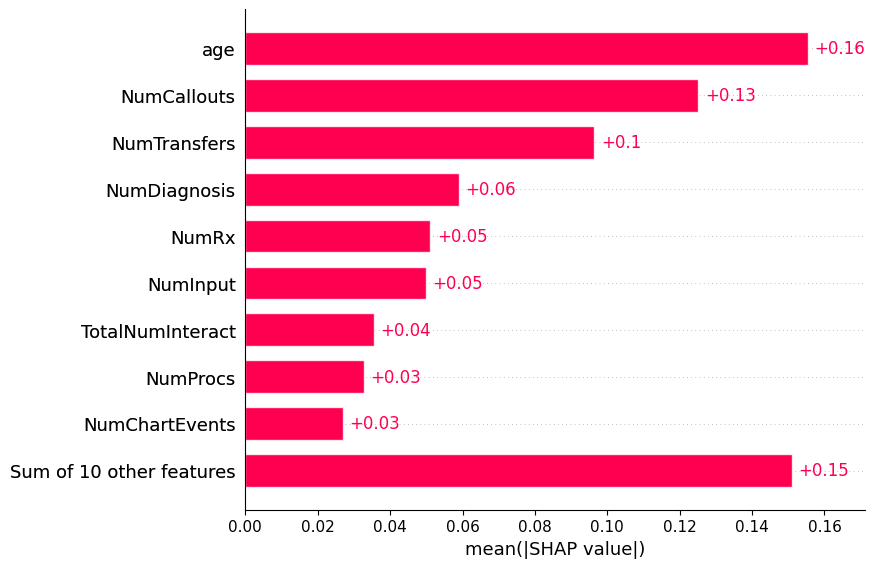

In [ ]:
# Function to train and evaluate the model
def evaluate_model(X_train, X_test, y_train, y_test):
    # Define the GBM model
    gbm = GradientBoostingClassifier()

    # Parameters for grid search
    param_grid = {
        'n_estimators': [50, 100],  # Number of boosting stages to be run
        'learning_rate': [0.01, 0.1],  # Step size shrinkage to prevent overfitting
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid,
                               scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

    # Adding noise to features
    noise_factor = 0.5
    X_train_noisy = X_train + noise_factor * np.random.normal(0, 1, X_train.shape)
    X_test_noisy = X_test + noise_factor * np.random.normal(0, 1, X_test.shape)

    # Adding noise to labels
    y_train_noisy = np.where(np.random.rand(len(y_train)) < noise_factor, np.random.randint(0, 2, size=len(y_train)), y_train)
    y_test_noisy = np.where(np.random.rand(len(y_test)) < noise_factor, np.random.randint(0, 2, size=len(y_test)), y_test)

    # Fit GridSearchCV on noisy training data
    grid_search.fit(X_train_noisy, y_train_noisy)

    # Get the best parameters and best estimator from GridSearchCV
    best_gbm = grid_search.best_estimator_

    # Predictions on the noisy test set
    y_pred = best_gbm.predict(X_test_noisy)
    y_prob = best_gbm.predict_proba(X_test_noisy) #For AUC ROC

    # Calculate confusion matrix
    cm = confusion_matrix(y_test_noisy, y_pred)
    print("Confusion Matrix:\n", cm)


    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in np.unique(y_test_noisy)])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Determine the number of classes based on noisy labels
    n_classes = len(np.unique(y_test_noisy))

    # Binarize the noisy test labels for multi-class ROC AUC
    y_test_binarized = label_binarize(y_test_noisy, classes=np.unique(y_test_noisy))

    # Initialize dictionaries to store FPR, TPR, and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotting the ROC Curve for each class
    plt.figure()
    colors = cycle(["blue", "green", "red", "orange", "purple", "cyan", "magenta"])
    for i, color in zip(range(n_classes), colors):
         plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve of class {i} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-class ROC Curve for GBM Model (with Noise)")
    plt.legend(loc="lower right")
    plt.show()

    # Calculate macro and weighted AUC scores
    macro_roc_auc = roc_auc_score(y_test_binarized, y_prob, average="macro")
    weighted_roc_auc = roc_auc_score(y_test_binarized, y_prob, average="weighted")

    print(f"Macro AUC: {macro_roc_auc:.2f}")
    print(f"Weighted AUC: {weighted_roc_auc:.2f}")

    # Evaluate the model with different metrics
    accuracy = accuracy_score(y_test_noisy, y_pred)
    precision = precision_score(y_test_noisy, y_pred, average='weighted')
    recall = recall_score(y_test_noisy, y_pred, average='weighted')
    f1 = f1_score(y_test_noisy, y_pred, average='weighted')
    auc_roc = roc_auc_score(y_test_noisy, best_gbm.predict_proba(X_test_noisy), multi_class='ovr')

    # Print evaluation metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    print(f"AUC-ROC: {auc_roc}")
    print(f"Best Parameters: {best_params}")

    # Assuming 'best_gbm' trained GradientBoostingClassifier model
    # and X_test is the test data.

    # Explain the model's predictions using SHAP
    # Use best_gbm.predict as the callable model for the explainer
    # and use X_train as background data for the masker
    explainer = shap.Explainer(best_gbm.predict, X_train)
    shap_values = explainer(X_test_noisy)

    # Create a summary plot of the feature importances
    shap.summary_plot(shap_values, X_test_noisy, plot_type="bar")

    # Alternatively, for a bar plot directly:
    shap.plots.bar(shap_values)

    return accuracy, precision, recall, f1, auc_roc, grid_search.best_params_


accuracy, precision, recall, f1,auc_roc, best_params = evaluate_model(X_train, X_test, y_train, y_test)


##XGBM Classifier Model

Best parameters found: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


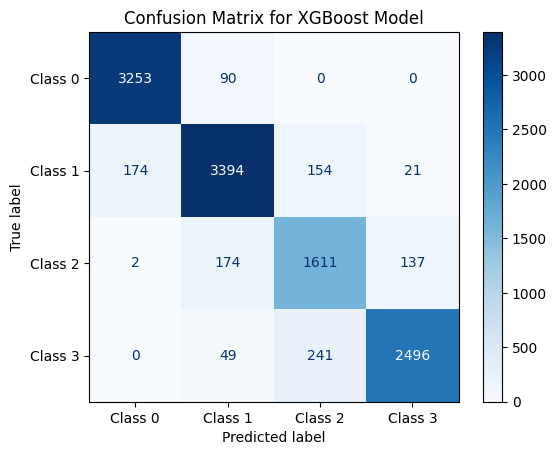

Accuracy: 0.91166497117667
Precision: 0.9124841211818017
Recall: 0.91166497117667
F1-score: 0.911837954893391
AUC-ROC: 0.9885072732813673


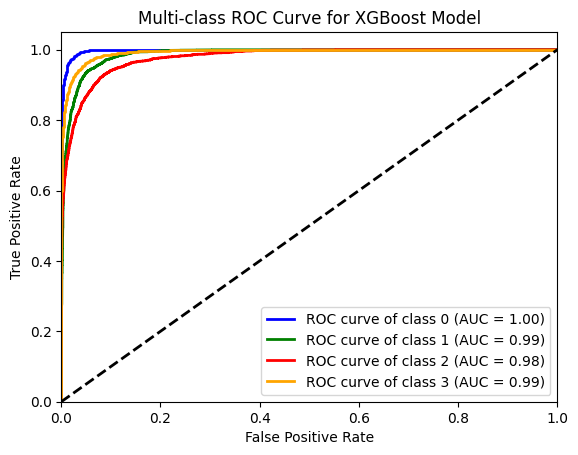

Macro AUC: 0.99
Weighted AUC: 0.99


In [ ]:
# del f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# parameter grid
param_grid = {
    'n_estimators': [50, 100], #the no of trees to be built
    'max_depth': [3, 5], #max depth of tree (controls overfitting)
    'learning_rate': [0.1, 0.01], #Shrinks the contribution of each tree.
}

# Initialize XGBoost classifier
xgb = XGBClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters found:", grid_search.best_params_)

# Predictions on the test set using the best model from grid search
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test) #For AUC ROC

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in np.unique(y_test)])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Model")
plt.show()

# Evaluate the model
accuracy_2 = accuracy_score(y_test, y_pred)
precision_2 = precision_score(y_test, y_pred, average='weighted')
recall_2 = recall_score(y_test, y_pred, average='weighted')
f1_2 = f1_score(y_test, y_pred, average='weighted')
auc_roc_2 = roc_auc_score(y_test, best_xgb.predict_proba(X_test), multi_class='ovr')

# Print evaluation metrics
print(f"Accuracy: {accuracy_2}")
print(f"Precision: {precision_2}")
print(f"Recall: {recall_2}")
print(f"F1-score: {f1_2}")
print(f"AUC-ROC: {auc_roc_2}")

# ROC Curve and AUC for Multi-class
n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC Curve
plt.figure()
colors = cycle(["blue", "green", "red", "orange", "purple"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve of class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve for XGBoost Model")
plt.legend(loc="lower right")
plt.show()

# Macro and Weighted AUC
macro_roc_auc = roc_auc_score(y_test_binarized, y_prob, average="macro")
weighted_roc_auc = roc_auc_score(y_test_binarized, y_prob, average="weighted")
print(f"Macro AUC: {macro_roc_auc:.2f}")
print(f"Weighted AUC: {weighted_roc_auc:.2f}")

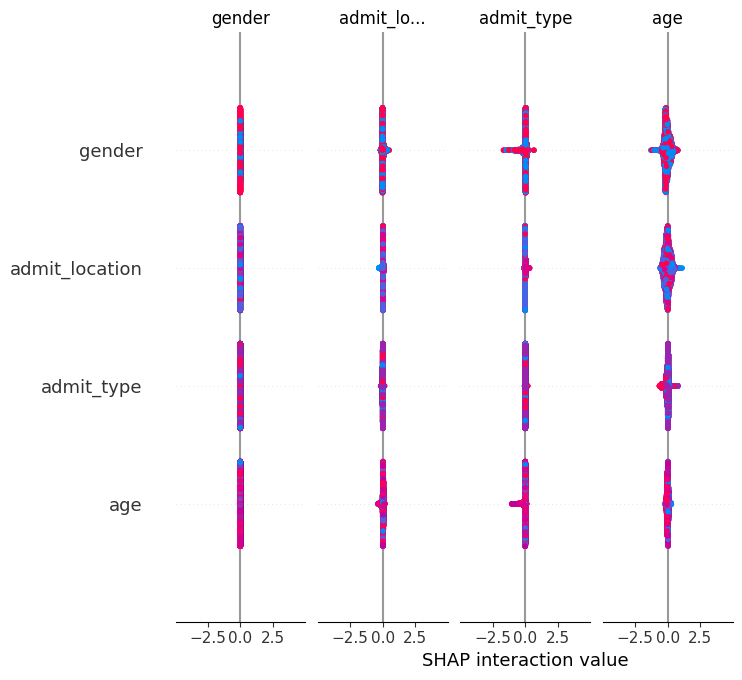

In [ ]:
import shap
# Calculate SHAP values
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

# Create a summary plot of the feature importances with a bar plot
plt.title("SHAP Summary Plot for XGBoost Model")
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Alternatively, for a bar plot directly:
#shap.plots.bar(shap_values[0])

# Alternatively, for a bar plot directly:
#shap.plots.bar(shap_values)




###Execution of Mam's code (XGB Classifier)

In [ ]:
# del f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import xgboost as xgb

# Initializing an XGBoost classifier

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],                  # Increase number of trees
    'max_depth': [3, 6, 10],                         # Limit tree depth
    'learning_rate': [0.01, 0.1, 0.2],               # Smaller learning rate for controlled growth
    'min_child_weight': [1, 5, 10],                  # Minimum sum of instance weight needed in a child
    'gamma': [0, 0.1, 0.5],                          # Minimum loss reduction to split
    'subsample': [0.8, 1.0],                         # Fraction of samples for each tree
    'colsample_bytree': [0.8, 1.0]                   # Fraction of features for each tree
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Extract the best model
best_xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate model on test data
y_pred = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Cross-validation score to check generalization
cv_scores = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy: ", np.mean(cv_scores))

# Feature importance analysis
feature_importances = best_xgb.feature_importances_
print("Feature Importances:", feature_importances)

# Display feature importance by feature
'''for feature, importance in zip(X.feature_names, feature_importances):
    print(f"{feature}: {importance:.4f}")'''



Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Test Accuracy: 0.7940827399118345
Cross-Validation Accuracy:  0.8037906291347268
Feature Importances: [0.09692574 0.02698661 0.05185155 0.07107709 0.05686614 0.03411519
 0.04394076 0.13944718 0.03279748 0.03082237 0.28867757 0.06041717
 0.03275591 0.03331921]


AttributeError: 'DataFrame' object has no attribute 'feature_names'

##Logistic Regression Model

Fitting 3 folds for each of 8 candidates, totalling 24 fits


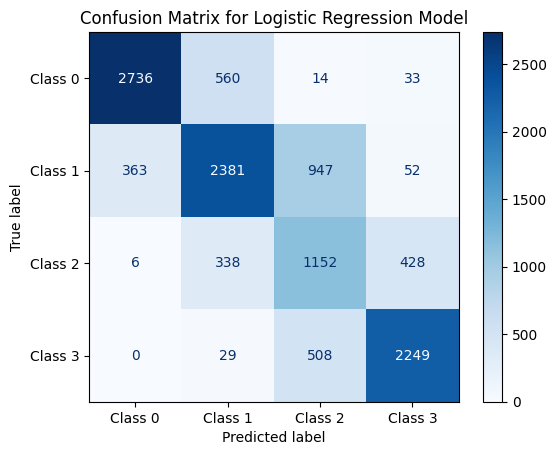

Accuracy: 0.7221091895557816
Precision: 0.7421166594692935
Recall: 0.7221091895557816
F1-score: 0.728971099360759
AUC-ROC: 0.9169921676671218
Best Parameters: {'C': 1.0, 'penalty': 'l2'}


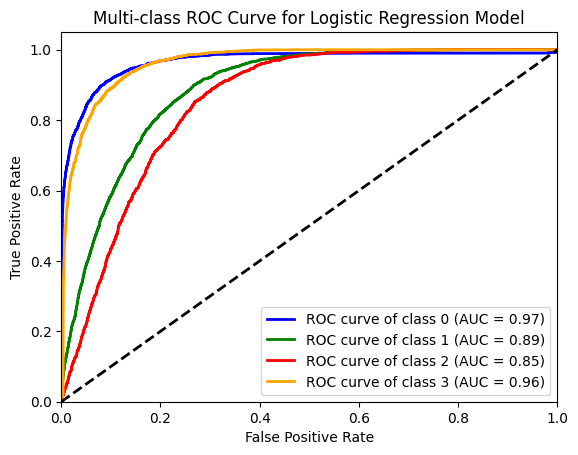

Macro AUC: 0.92
Weighted AUC: 0.92


In [ ]:
# Define the Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# parameters for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0],  # Inverse of regularization strength (smaller values specify stronger regularization)
    'penalty': ['l1', 'l2'],  # Regularization type: L1 (Lasso) or L2 (Ridge)
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid,
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator from GridSearchCV
best_params = grid_search.best_params_
best_logreg = grid_search.best_estimator_

# Predictions on the test set
y_pred = best_logreg.predict(X_test)
y_prob = best_logreg.predict_proba(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in np.unique(y_test)])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression Model")
plt.show()

# Evaluate the model
accuracy_3 = accuracy_score(y_test, y_pred)
precision_3 = precision_score(y_test, y_pred, average='weighted')
recall_3 = recall_score(y_test, y_pred, average='weighted')
f1_3 = f1_score(y_test, y_pred, average='weighted')
auc_roc_3 = roc_auc_score(y_test, best_logreg.predict_proba(X_test), multi_class='ovr')

# Print evaluation metrics
print(f"Accuracy: {accuracy_3}")
print(f"Precision: {precision_3}")
print(f"Recall: {recall_3}")
print(f"F1-score: {f1_3}")
print(f"AUC-ROC: {auc_roc_3}")

# Print best parameters
print(f"Best Parameters: {best_params}")

# ROC Curve and AUC for Multi-class
n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC Curve
plt.figure()
colors = cycle(["blue", "green", "red", "orange", "purple"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve of class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve for Logistic Regression Model")
plt.legend(loc="lower right")
plt.show()

# Macro and Weighted AUC
macro_roc_auc = roc_auc_score(y_test_binarized, y_prob, average="macro")
weighted_roc_auc = roc_auc_score(y_test_binarized, y_prob, average="weighted")
print(f"Macro AUC: {macro_roc_auc:.2f}")
print(f"Weighted AUC: {weighted_roc_auc:.2f}")

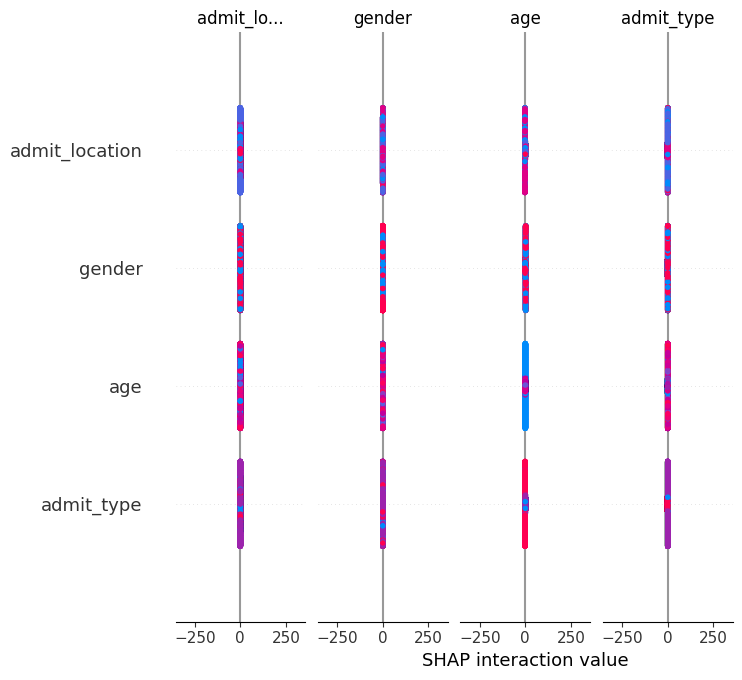

In [ ]:

import shap

# Explain the model's predictions using SHAP
explainer = shap.Explainer(best_logreg, X_train) #Using X_train for the explainer
shap_values = explainer.shap_values(X_test)

# Create a summary plot of the feature importances with a bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Alternatively, for a bar plot directly:
#shap.plots.bar(shap_values)

##Random Forest Model

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Accuracy: 0.9084435401831129
Precision: 0.9085285095715495
Recall: 0.9084435401831129
F1-score: 0.9084301355209154
AUC-ROC: 0.987481247671423
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


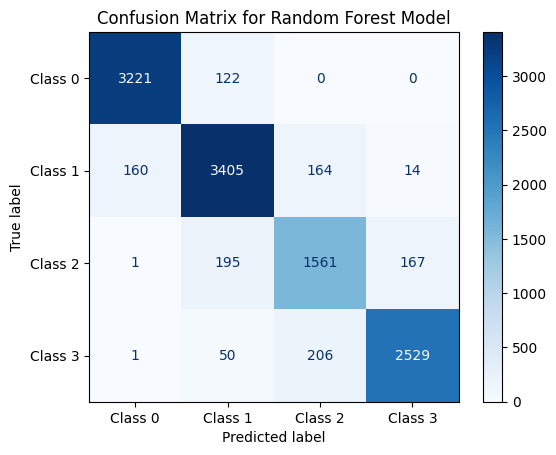

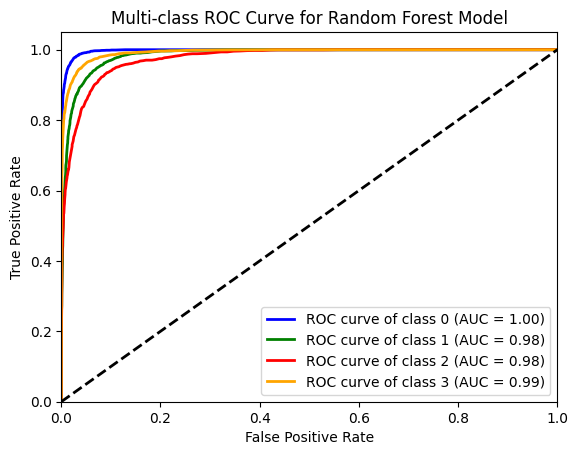

Macro AUC: 0.99
Weighted AUC: 0.99


In [ ]:
# Random Forest Algorithm

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Parameters for grid search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator from GridSearchCV
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

# Predictions on the test set
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred, average='weighted')
recall_rf = recall_score(y_test, y_pred, average='weighted')
f1_rf = f1_score(y_test, y_pred, average='weighted')
auc_roc_rf = roc_auc_score(y_test, best_rf.predict_proba(X_test), multi_class='ovr')

# Print evaluation metrics
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1-score: {f1_rf}")
print(f"AUC-ROC: {auc_roc_rf}")

# Print best parameters
print(f"Best Parameters: {best_params}")

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in np.unique(y_test)])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Random Forest Model")
plt.show()

# 2. ROC Curve and AUC for Multi-class
n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC Curve
plt.figure()
colors = cycle(["blue", "green", "red", "orange", "purple"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve of class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve for Random Forest Model")
plt.legend(loc="lower right")
plt.show()

# Calculate macro and weighted AUC scores
macro_roc_auc = roc_auc_score(y_test_binarized, y_prob, average="macro")
weighted_roc_auc = roc_auc_score(y_test_binarized, y_prob, average="weighted")

print(f"Macro AUC: {macro_roc_auc:.2f}")
print(f"Weighted AUC: {weighted_roc_auc:.2f}")


In [ ]:
import shap

# SHAP Analysis
explainer = shap.Explainer(best_rf, X_train)
shap_values = explainer(X_test)

# SHAP Summary Plot (Bar plot)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)

 48%|==========          | 22616/47184 [84:26<91:43]       

###Trying with changing the parameters!!

###Execution of Mam's Code (Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)


# Define a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],           # Number of trees in the forest
    'max_depth': [5, 10, None],                # Limit the depth of each tree
    'min_samples_split': [2, 5, 10],           # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],             # Minimum samples required at each leaf node
    'max_features': ['sqrt', 'log2', None],    # Number of features to consider at each split
    'bootstrap': [True, False]                 # Use bootstrapping to increase randomness
}

# Set up Random Forest with Cross-Validation for hyperparameter tuning
rf = RandomForestClassifier(random_state=42, oob_score=True)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Extract the best estimator after hyperparameter tuning
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model on test data
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Cross-validation score to evaluate generalization
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy: ", np.mean(cv_scores))

# Check Out-of-Bag (OOB) error if bootstrapping was enabled
if best_rf.bootstrap:
    print("OOB Score:", best_rf.oob_score_)

# Feature importance analysis (optional)
feature_importances = best_rf.feature_importances_
print("Feature Importances:", feature_importances)

# Display the importance of each feature
for feature, importance in zip(X.feature_names, feature_importances):
    print(f"{feature}: {importance:.4f}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
AUC-ROC: 1.0
Best Parameters: {'bootstrap': True, 'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


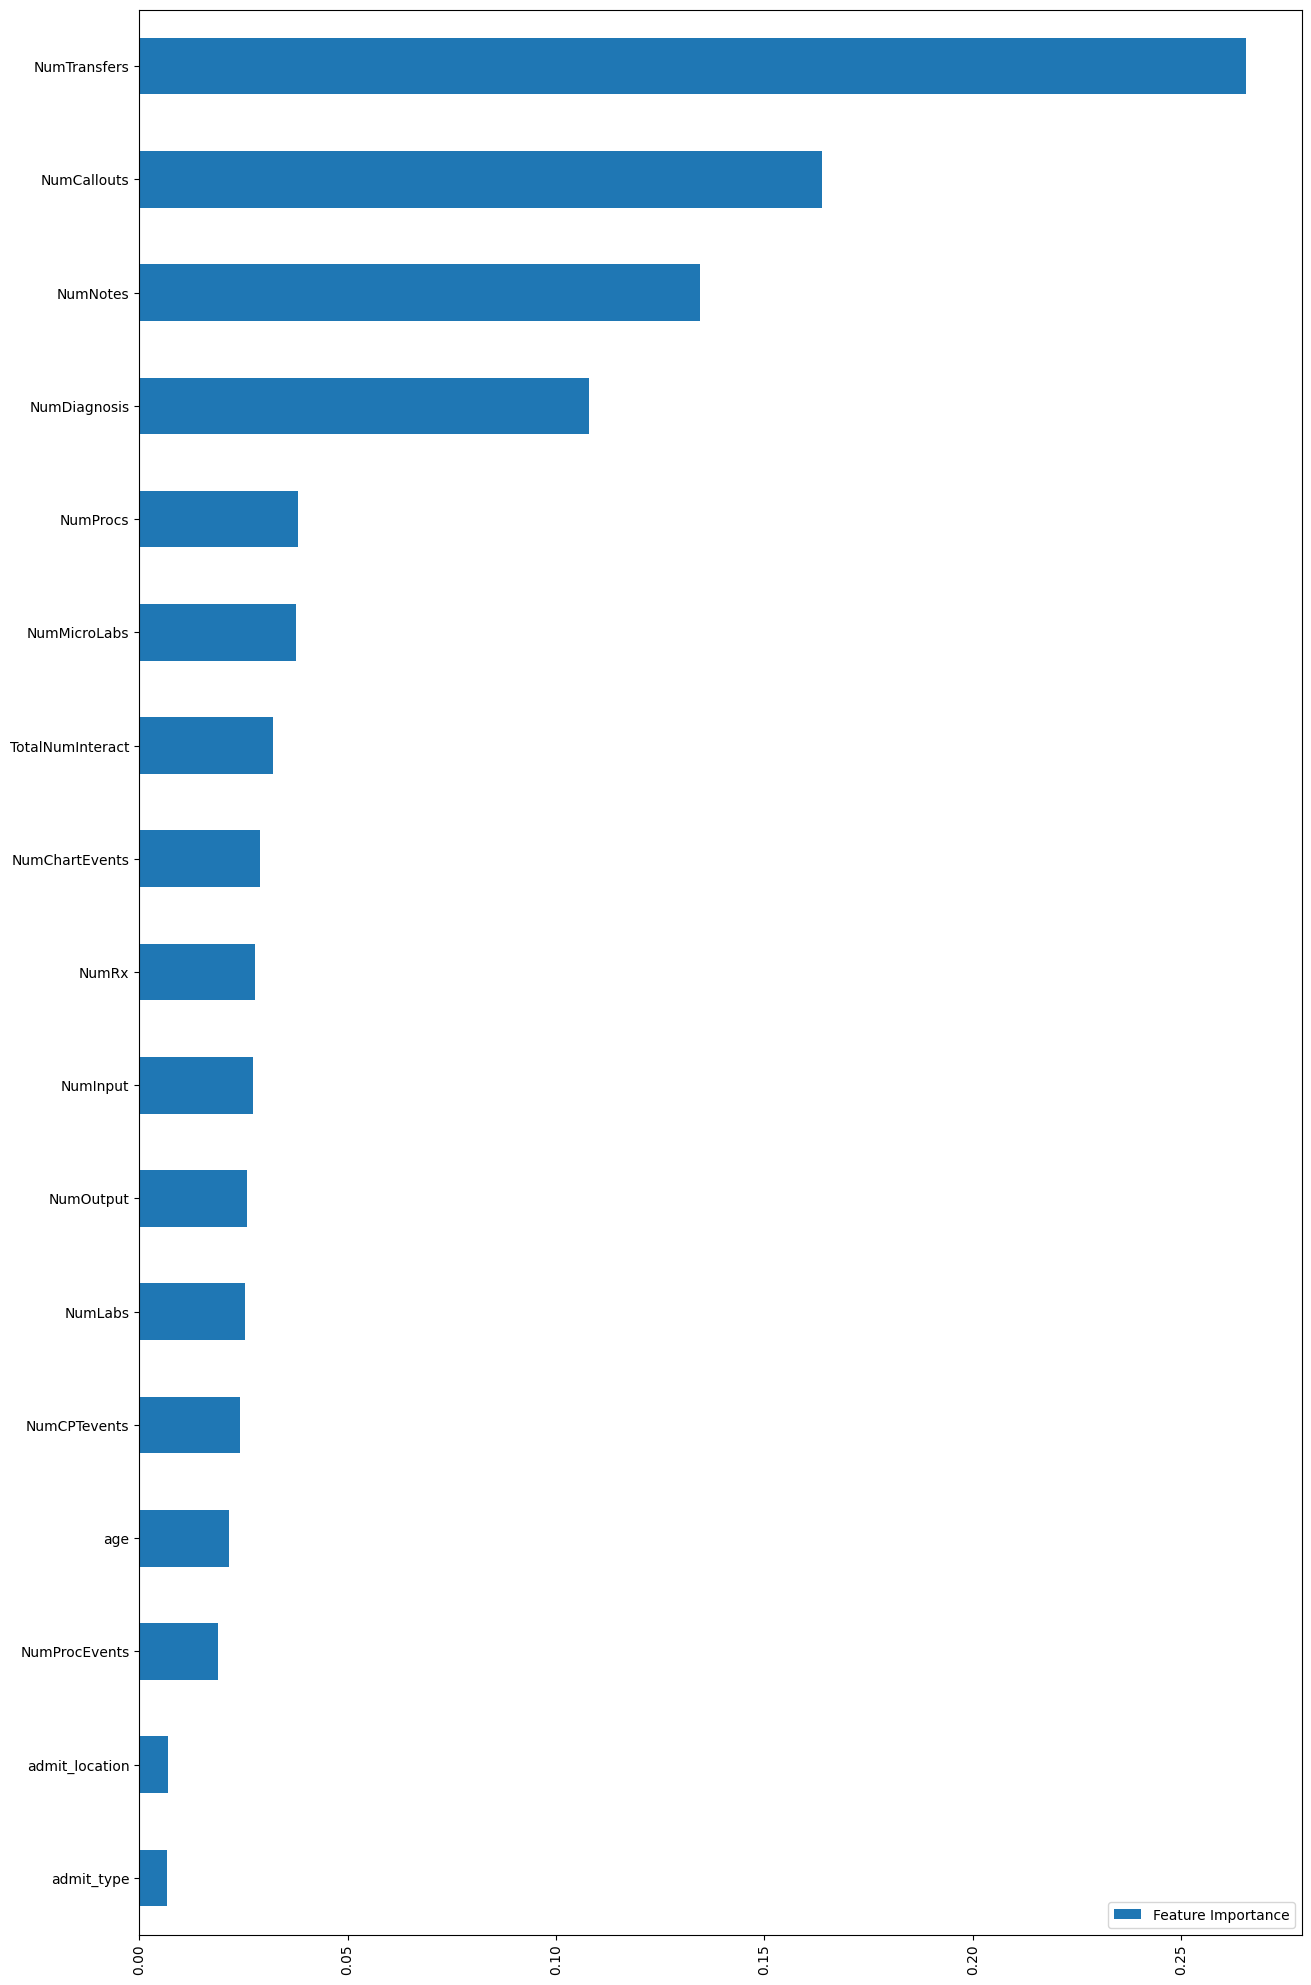

In [ ]:
# FEATURE IMPORTANCE - NORMALIZED

trainFinalFI = XNorm
yFinalFI = y

# Initialize the RandomForestClassifier
model = RandomForestClassifier(random_state=42)

model.fit(trainFinalFI,yFinalFI)

FI_model = pd.DataFrame({"Feature Importance":model.feature_importances_,}, index=trainFinalFI.columns)
FI_model[FI_model["Feature Importance"] > 0.005].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# List of important features for model
FI_model = pd.DataFrame({"Feature Importance":model.feature_importances_,}, index=trainFinalFI.columns)
FI_model=FI_model.sort_values('Feature Importance', ascending = False)
print(FI_model[FI_model["Feature Importance"] > 0.001])

                   Feature Importance
NumTransfers                 0.265687
NumCallouts                  0.163785
NumNotes                     0.134647
NumDiagnosis                 0.107963
NumProcs                     0.038218
NumMicroLabs                 0.037523
TotalNumInteract             0.032150
NumChartEvents               0.029029
NumRx                        0.027811
NumInput                     0.027423
NumOutput                    0.025762
NumLabs                      0.025418
NumCPTevents                 0.024097
age                          0.021538
NumProcEvents                0.018857
admit_location               0.007004
admit_type                   0.006685
arrival_transport            0.003423
gender                       0.002981
